Daniel Ayer<br>
Data Mining CS634852<br>
Final Project<br>


In [1]:
# Import Libraries

# Base Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# SKlearn
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Keras
import keras
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# TensorFlow
import tensorflow as tf


2024-04-21 16:32:27.438891: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-21 16:32:27.440371: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-21 16:32:27.462741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 16:32:27.462756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 16:32:27.463383: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# User Defined Functions and Variables


In [2]:
def random_forest(train_index, test_index, display = False):
    
    features_train = features.iloc[train_index]
    labels_train = labels.iloc[train_index]
    
    features_test = features.iloc[test_index]
    labels_test = labels.iloc[test_index]
    
    # Random Forest
    clf = RandomForestClassifier(max_depth = 2, random_state = 42)

    clf.fit(features_train, labels_train)
       
    # Make Predictions
    predictions = clf.predict(features_test)

    print("Random Forest Accuracy:",metrics.accuracy_score(labels_test, predictions))

    # Get Evaluation Metrics.
    df_random_forest_metrics = classifier_metrics(labels_test, predictions)

    # Display figures if asked.
    if display == True:
        
        fig = plt.figure(figsize=(15, 10))

        plot_tree(clf.estimators_[0], 
                  feature_names = features.columns,
                  filled=True, rounded=True)

        plt.savefig('decisionTree.eps',format = 'eps',bbox_inches = "tight")

        plt.show()
    
    return df_random_forest_metrics


In [3]:
def deep_learning(train_index, test_index):
    
    # Set control variables.
   
    # Threshold to take labels based on probabilities.
    prob_thresh = 0.5
    
    # Convert data to numpy array.
    features_train, features_test, labels_train, labels_test = map(np.array, 
        [features.iloc[train_index],
         features.iloc[test_index], 
         labels.iloc[train_index], 
         labels.iloc[test_index]])

    # Reshape Data
    shape = features_train.shape
    features_train = features_train.reshape(len(features_train), shape[1], 1)
    features_test = features_test.reshape(len(features_test), shape[1], 1)

    # Build LSTM model.
    lstm_model = Sequential()
    lstm_model.add(LSTM(90, activation = 'relu'))
    lstm_model.add(Dense(1, activation = 'sigmoid', name = "second_layer"))

    
    lstm_model.compile(optimizer = 'adam', 
                            loss = 'binary_crossentropy',  
                            metrics = ['accuracy'])
    
    # Call model on training data to set weights.
    lstm_model(features_train)
    
    # Display Model Summary
    lstm_model.summary()
    
    # Fit Model
    lstm_model.fit(features_train, labels_train, epochs = 50)
    
    ## Save Model ##
    
    models_dir = "models"
    
    # List directory contents.
    models_store = os.listdir(models_dir)

    # Number iteration
    model_num = len(models_store)

    # Save model.
    uri = models_dir + "/lstm_model_" + str(model_num) + ".keras"
    lstm_model.save(uri)
    
    # Display scores
    scores = lstm_model.evaluate(features_test, labels_test)
    print("scores: ", scores)
    
    # Predict
    pred_prob = lstm_model.predict(features_test)
    predictions = pred_prob > prob_thresh
    predictions = predictions.astype(int)
    
    # Get Evaluation Metrics.
    df_deep_learning_metrics = classifier_metrics(labels_test, predictions)
    
    return df_deep_learning_metrics


In [4]:
def knn(train_index, test_index):
    
    features_train = features.iloc[train_index]
    labels_train = labels.iloc[train_index]
    
    features_test = features.iloc[test_index]
    labels_test = labels.iloc[test_index]
    
    # Define classifier.
    neigh = KNeighborsClassifier(n_neighbors = 5)

    # Fit Classifier
    neigh.fit(features_train, labels_train)

    # Make Predictions
    predictions = neigh.predict(features_test)    
    
    # Evaluate 
    neigh.score(features_test, labels_test)

    # Return Metrics
    df_knn_metrics = classifier_metrics(labels_test, predictions)
    
    return df_knn_metrics


In [5]:
def metrics_df():
    
       
    df = pd.DataFrame(dtype = 'float',
                       columns = ["FP", "FN", "TP", "TN", "P", "N", "TPR", "TNR", "FPR", "FNR", "r", "PPV", 
                                  "f1", "NPV", "FDR", "ACC", "BACC", "TSS", "HSS"])
    
    return df


In [6]:
def classifier_metrics(y_test, predictions):
    # This function returns the parameters evaluating the performance of our classifier.    
    
    # Create confusion matrix.
    conf_mat = confusion_matrix(y_test, predictions)

    # Create dataframe to display metrics.
    df = metrics_df()
    
    # Get Evaluation Metrics.

    # False Positive
    FP = conf_mat[0,1]

    # False Negative
    FN = conf_mat[1,0]

    # True Positive
    TP = conf_mat[0,0]

    # True Negative
    TN = conf_mat[1,1]

    # Positive Examples.
    P = TP + FN
    
    # Negative Examples.
    N = TN + FP
    
    # True Positive Rate
    if TP + FN != 0:
        
        TPR = TP/(TP+FN)
        
    else:
        
        TPR = 0
        
    # True Negative Rate
    if TN + FP != 0:
        
        TNR = TN/(TN+FP) 
        
    else:
        
        TNR = 0
    
    # False Positive Rate
    if N != 0:
        
        FPR = FP / N
    else:
        
        FPR = 0
    
    # False Negative Rate
    if P != 0:
        
        FNR = FN / P
    
    else:
        
        FNR = 0
    
    # Recall / Sensitivity
    if P != 0:
        
        r = TP / P
    
    else:
        
        r = 0
    
    # Precision or positive predictive value
    if TP + FP != 0:
        
        PPV = TP/(TP+FP)
    
    else:
        
        PPV = 0
    
    #F1 Measure
    if PPV + r != 0:
        
        f1 = 2 * (PPV * r) / (PPV + r)
        
    else:
        
        f1 = 0
        
    # Negative predictive value
    if TN + FN != 0:
        
        NPV = TN/(TN+FN)
    
    else:
        
        NPV = 0
        
    # False discovery rate
    if TP + FP != 0:
        
        FDR = FP/(TP+FP)

    else:
        
        FDR = 0
        
    # Overall accuracy
    if TP + FP + FN + TN != 0:
        
        ACC = (TP+TN)/(TP+FP+FN+TN)

    else:
        
        ACC = 0
    
    # Error Rate
    if TP + FP + FN + TN != 0:
        
        err_rate = (FP + FN) / (TP+FP+FN+TN)
    
    else:
        
        err_rate = 0
    
    # BACC
    BACC = (TPR + TNR) / 2
              
    # TSS 
    TSS = TPR - FPR
                
    # HSS
    if ((TP + FN) * (FN + TN) * (TP + FP) * (FP + TN)) != 0:
        
        HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) * (TP + FP) * (FP + TN))
    
    else:
                      
        HSS = 0
                      
    # Store values in dataframe.
    df.loc[0] = [FP, FN, TP, TN, P, N, TPR, TNR, FPR, FNR, r, PPV, f1, NPV, FDR, ACC, BACC, TSS, HSS]

    # Return DataFrame.
    return df


# Exploratory Data Analysis (EDA)



# Data Source

https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

Usability: 10.00

License:
Data files © Original Authors

Expected update frequency:
Never

About Dataset
Similar Datasets

    The Boston House-Price Dat
    Gender Pay Gap Dataset
    Spanish Wine Quality Dataset

Context

The data were collected from the Taiwan Economic Journal for the years 1999 to 2009. Company bankruptcy was defined based on the business regulations of the Taiwan Stock Exchange.
Attribute Information

Version 2: Updated column names and description to make the data easier to understand (Y = Output feature, X = Input features)

Y - Bankrupt?: Class label
X1 - ROA(C) before interest and depreciation before interest: Return On Total Assets(C)
X2 - ROA(A) before interest and % after tax: Return On Total Assets(A)
X3 - ROA(B) before interest and depreciation after tax: Return On Total Assets(B)
X4 - Operating Gross Margin: Gross Profit/Net Sales
X5 - Realized Sales Gross Margin: Realized Gross Profit/Net Sales
X6 - Operating Profit Rate: Operating Income/Net Sales
X7 - Pre-tax net Interest Rate: Pre-Tax Income/Net Sales
X8 - After-tax net Interest Rate: Net Income/Net Sales
X9 - Non-industry income and expenditure/revenue: Net Non-operating Income Ratio
X10 - Continuous interest rate (after tax): Net Income-Exclude Disposal Gain or Loss/Net Sales
X11 - Operating Expense Rate: Operating Expenses/Net Sales
X12 - Research and development expense rate: (Research and Development Expenses)/Net Sales
X13 - Cash flow rate: Cash Flow from Operating/Current Liabilities
X14 - Interest-bearing debt interest rate: Interest-bearing Debt/Equity
X15 - Tax rate (A): Effective Tax Rate
X16 - Net Value Per Share (B): Book Value Per Share(B)
X17 - Net Value Per Share (A): Book Value Per Share(A)
X18 - Net Value Per Share (C): Book Value Per Share(C)
X19 - Persistent EPS in the Last Four Seasons: EPS-Net Income
X20 - Cash Flow Per Share
X21 - Revenue Per Share (Yuan ¥): Sales Per Share
X22 - Operating Profit Per Share (Yuan ¥): Operating Income Per Share
X23 - Per Share Net profit before tax (Yuan ¥): Pretax Income Per Share
X24 - Realized Sales Gross Profit Growth Rate
X25 - Operating Profit Growth Rate: Operating Income Growth
X26 - After-tax Net Profit Growth Rate: Net Income Growth
X27 - Regular Net Profit Growth Rate: Continuing Operating Income after Tax Growth
X28 - Continuous Net Profit Growth Rate: Net Income-Excluding Disposal Gain or Loss Growth
X29 - Total Asset Growth Rate: Total Asset Growth
X30 - Net Value Growth Rate: Total Equity Growth
X31 - Total Asset Return Growth Rate Ratio: Return on Total Asset Growth
X32 - Cash Reinvestment %: Cash Reinvestment Ratio
X33 - Current Ratio
X34 - Quick Ratio: Acid Test
X35 - Interest Expense Ratio: Interest Expenses/Total Revenue
X36 - Total debt/Total net worth: Total Liability/Equity Ratio
X37 - Debt ratio %: Liability/Total Assets
X38 - Net worth/Assets: Equity/Total Assets
X39 - Long-term fund suitability ratio (A): (Long-term Liability+Equity)/Fixed Assets
X40 - Borrowing dependency: Cost of Interest-bearing Debt
X41 - Contingent liabilities/Net worth: Contingent Liability/Equity
X42 - Operating profit/Paid-in capital: Operating Income/Capital
X43 - Net profit before tax/Paid-in capital: Pretax Income/Capital
X44 - Inventory and accounts receivable/Net value: (Inventory+Accounts Receivables)/Equity
X45 - Total Asset Turnover
X46 - Accounts Receivable Turnover
X47 - Average Collection Days: Days Receivable Outstanding
X48 - Inventory Turnover Rate (times)
X49 - Fixed Assets Turnover Frequency
X50 - Net Worth Turnover Rate (times): Equity Turnover
X51 - Revenue per person: Sales Per Employee
X52 - Operating profit per person: Operation Income Per Employee
X53 - Allocation rate per person: Fixed Assets Per Employee
X54 - Working Capital to Total Assets
X55 - Quick Assets/Total Assets
X56 - Current Assets/Total Assets
X57 - Cash/Total Assets
X58 - Quick Assets/Current Liability
X59 - Cash/Current Liability
X60 - Current Liability to Assets
X61 - Operating Funds to Liability
X62 - Inventory/Working Capital
X63 - Inventory/Current Liability
X64 - Current Liabilities/Liability
X65 - Working Capital/Equity
X66 - Current Liabilities/Equity
X67 - Long-term Liability to Current Assets
X68 - Retained Earnings to Total Assets
X69 - Total income/Total expense
X70 - Total expense/Assets
X71 - Current Asset Turnover Rate: Current Assets to Sales
X72 - Quick Asset Turnover Rate: Quick Assets to Sales
X73 - Working capitcal Turnover Rate: Working Capital to Sales
X74 - Cash Turnover Rate: Cash to Sales
X75 - Cash Flow to Sales
X76 - Fixed Assets to Assets
X77 - Current Liability to Liability
X78 - Current Liability to Equity
X79 - Equity to Long-term Liability
X80 - Cash Flow to Total Assets
X81 - Cash Flow to Liability
X82 - CFO to Assets
X83 - Cash Flow to Equity
X84 - Current Liability to Current Assets
X85 - Liability-Assets Flag: 1 if Total Liability exceeds Total Assets, 0 otherwise
X86 - Net Income to Total Assets
X87 - Total assets to GNP price
X88 - No-credit Interval
X89 - Gross Profit to Sales
X90 - Net Income to Stockholder's Equity
X91 - Liability to Equity
X92 - Degree of Financial Leverage (DFL)
X93 - Interest Coverage Ratio (Interest expense to EBIT)
X94 - Net Income Flag: 1 if Net Income is Negative for the last two years, 0 otherwise
X95 - Equity to Liability
Source

Deron Liang and Chih-Fong Tsai, deronliang '@' gmail.com; cftsai '@' mgt.ncu.edu.tw, National Central University, Taiwan
The data was obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Taiwanese+Bankruptcy+Prediction
Relevant Papers

Liang, D., Lu, C.-C., Tsai, C.-F., and Shih, G.-A. (2016) Financial Ratios and Corporate Governance Indicators in Bankruptcy Prediction: A Comprehensive Study. European Journal of Operational Research, vol. 252, no. 2, pp. 561-572.
https://www.sciencedirect.com/science/article/pii/S0377221716000412

In [7]:
# Read in dataset

df = pd.read_csv("data.csv")


In [8]:
# Examine dataset

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   bankrupt                                                  6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [9]:
df.head(20)


bankrupt   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          
5          1                                           0.388680          
6          0                                           0.390923          
7          0                                           0.508361          
8          0                                           0.488519          
9          0                                           0.495686          
10         0                                           0.482475          
11         0                                           0.444401          
12         0                                           0.491152          
13         0                                           0.474041          
14         0                                           0.506703          
15         0                                           0.513821          
16         0                                           0.488909          
17         0                                           0.535953          
18         0                                           0.504071          
19         0                                           0.487398          

     ROA(A) before interest and % after tax  \
0                                  0.424389   
1                                  0.538214   
2                                  0.499019   
3                                  0.451265   
4                                  0.538432   
5                                  0.415177   
6                                  0.445704   
7                                  0.570922   
8                                  0.545137   
9                                  0.550916   
10                                 0.567543   
11                                 0.549717   
12                                 0.551570   
13                                 0.533308   
14                                 0.575829   
15                                 0.571086   
16                                 0.560238   
17                                 0.590438   
18                                 0.559802   
19                                 0.543720   

     ROA(B) before interest and depreciation after tax  \
0                                            0.405750    
1                                            0.516730    
2                                            0.472295    
3                                            0.457733    
4                                            0.522298    
5                                            0.419134    
6                                            0.436158    
7                                            0.559077    
8                                            0.543284    
9                                            0.542963    
10                                           0.538198    
11                                           0.498956    
12                                           0.543391    
13                                           0.523690    
14                                           0.569838    
15                                           0.558756    
16                                           0.540286    
17                                           0.580920    
18                                           0.558649    
19                                           0.533647    

     Operating Gross Margin   Realized Sales Gross Margin  \
0                  0.601457                      0.601457   
1                  0.610235                      0.610235   
2                  0.601450                      0.601364  

In [10]:
# Describe Dataframe.

# Set formatting options.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '${:,.2f}'.format)

# Display 
df.describe().T



count  \
bankrupt                                           $6,819.00   
 ROA(C) before interest and depreciation before... $6,819.00   
 ROA(A) before interest and % after tax            $6,819.00   
 ROA(B) before interest and depreciation after tax $6,819.00   
 Operating Gross Margin                            $6,819.00   
 Realized Sales Gross Margin                       $6,819.00   
 Operating Profit Rate                             $6,819.00   
 Pre-tax net Interest Rate                         $6,819.00   
 After-tax net Interest Rate                       $6,819.00   
 Non-industry income and expenditure/revenue       $6,819.00   
 Continuous interest rate (after tax)              $6,819.00   
 Operating Expense Rate                            $6,819.00   
 Research and development expense rate             $6,819.00   
 Cash flow rate                                    $6,819.00   
 Interest-bearing debt interest rate               $6,819.00   
 Tax rate (A)                                      $6,819.00   
 Net Value Per Share (B)                           $6,819.00   
 Net Value Per Share (A)                           $6,819.00   
 Net Value Per Share (C)                           $6,819.00   
 Persistent EPS in the Last Four Seasons           $6,819.00   
 Cash Flow Per Share                               $6,819.00   
 Revenue Per Share (Yuan ¥)                        $6,819.00   
 Operating Profit Per Share (Yuan ¥)               $6,819.00   
 Per Share Net profit before tax (Yuan ¥)          $6,819.00   
 Realized Sales Gross Profit Growth Rate           $6,819.00   
 Operating Profit Growth Rate                      $6,819.00   
 After-tax Net Profit Growth Rate                  $6,819.00   
 Regular Net Profit Growth Rate                    $6,819.00   
 Continuous Net Profit Growth Rate                 $6,819.00   
 Total Asset Growth Rate                           $6,819.00   
 Net Value Growth Rate                             $6,819.00   
 Total Asset Return Growth Rate Ratio              $6,819.00   
 Cash Reinvestment %                               $6,819.00   
 Current Ratio                                     $6,819.00   
 Quick Ratio                                       $6,819.00   
 Interest Expense Ratio                            $6,819.00   
 Total debt/Total net worth                        $6,819.00   
 Debt ratio %                                      $6,819.00   
 Net worth/Assets                                  $6,819.00   
 Long-term fund suitability ratio (A)              $6,819.00   
 Borrowing dependency                              $6,819.00   
 Contingent liabilities/Net worth                  $6,819.00   
 Operating profit/Paid-in capital                  $6,819.00   
 Net profit before tax/Paid-in capital             $6,819.00   
 Inventory and accounts receivable/Net value       $6,819.00   
 Total Asset Turnover                              $6,819.00   
 Accounts Receivable Turnover                      $6,819.00   
 Average Collection Days                           $6,819.00   
 Inventory Turnover Rate (times)                   $6,819.00   
 Fixed Assets Turnover Frequency                   $6,819.00   
 Net Worth Turnover Rate (times)                   $6,819.00   
 Revenue per person                                $6,819.00   
 Operating profit per person                       $6,819.00   
 Allocation rate per person                        $6,819.00   
 Working Capital to Total Assets                   $6,819.00   
 Quick Assets/Total Assets                         $6,819.00   
 Current Assets/Total Assets                       $6,819.00   
 Cash/Total Assets                                 $6,819.00   
 Quick Assets/Current Liability                    $6,819.00   
 Cash/Current Liability                            $6,819.00   
 Current Liability to Assets                       $6,819.00   
 Operating Funds to Liability                      $6,819.00   
 Inventory/Working Capi

In [11]:
# Reset formatting options.
pd.set_option('display.float_format', None)


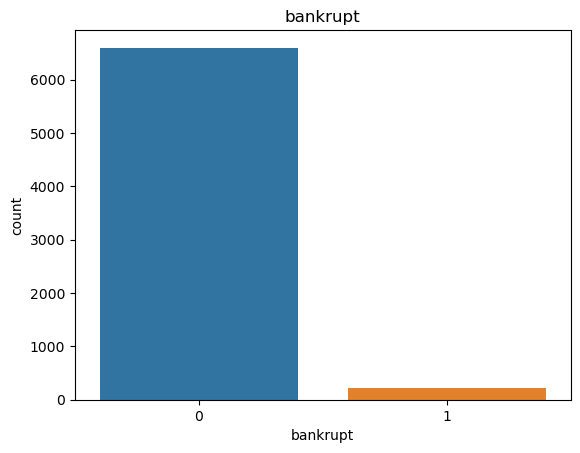

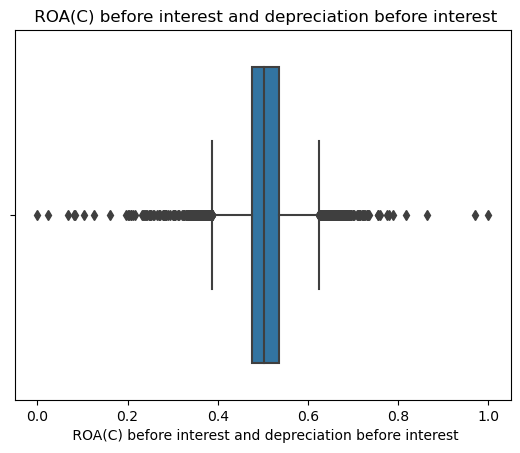

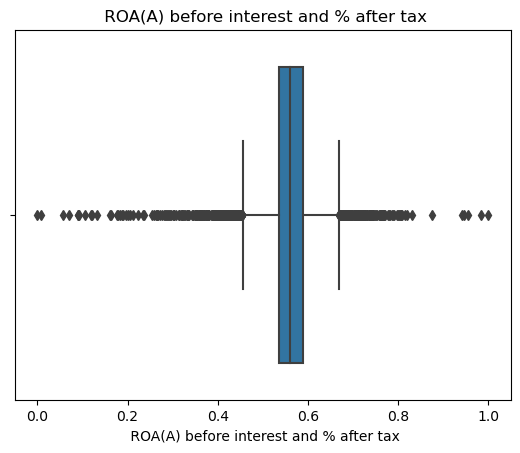

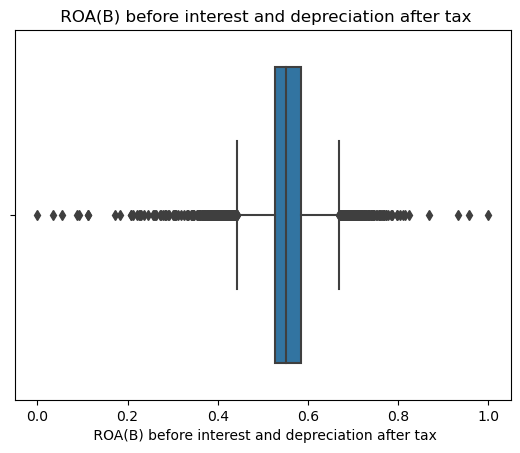

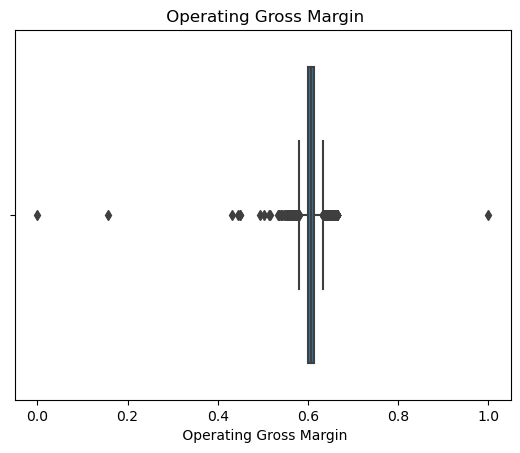

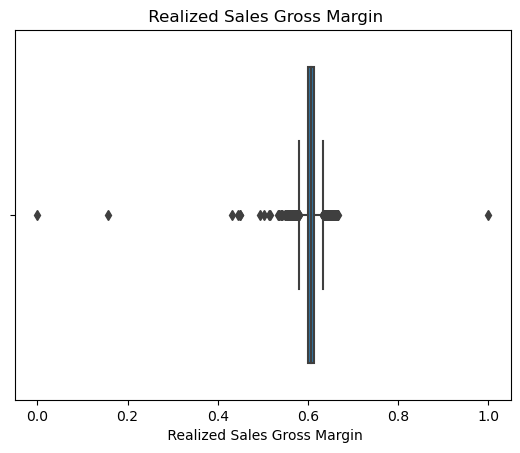

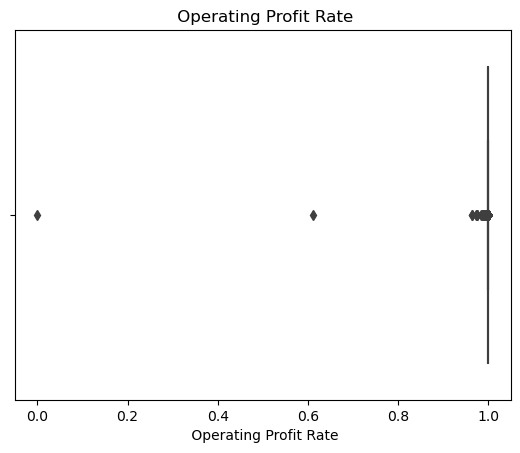

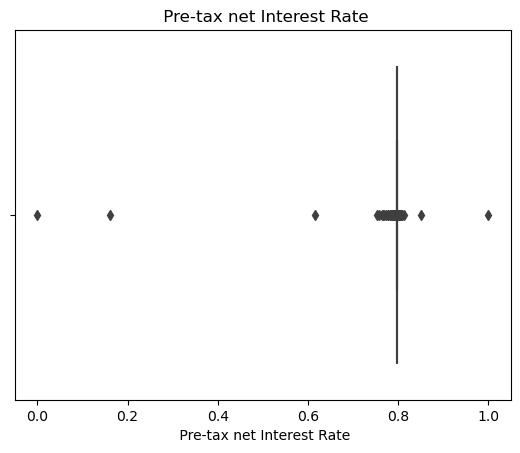

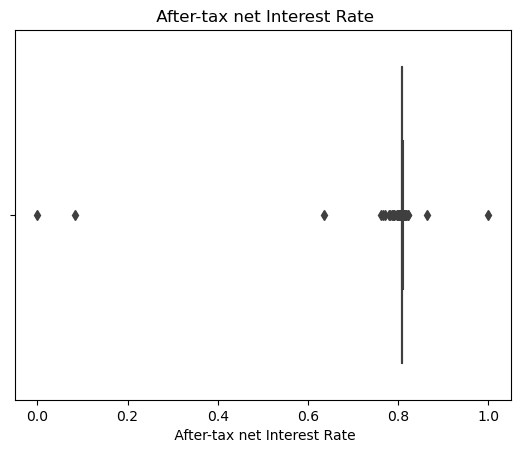

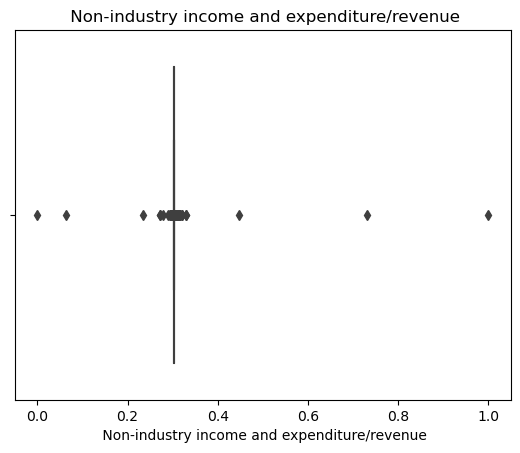

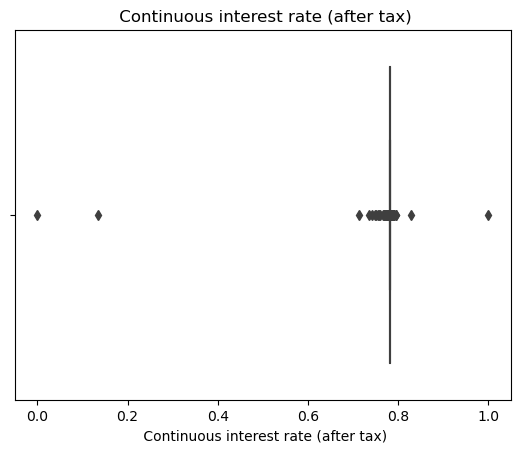

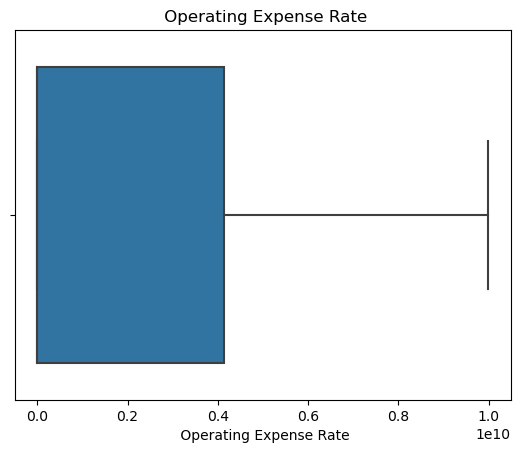

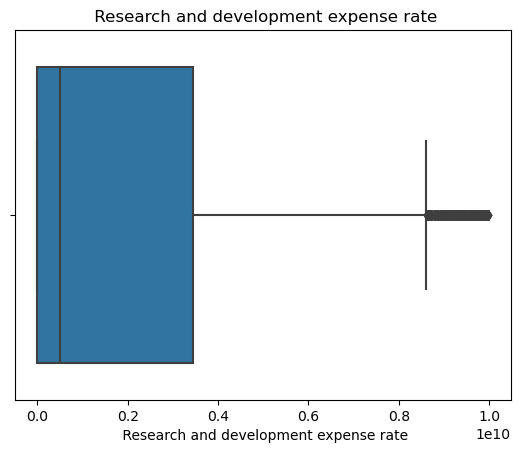

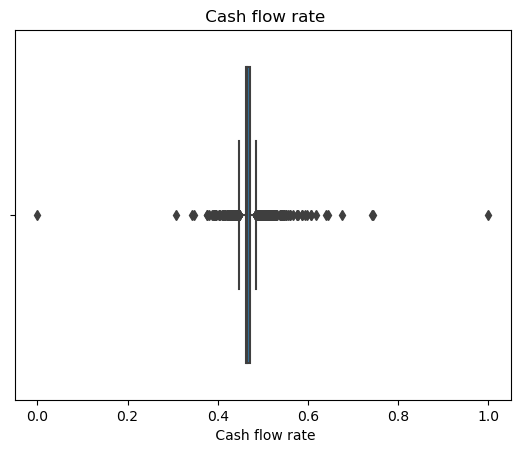

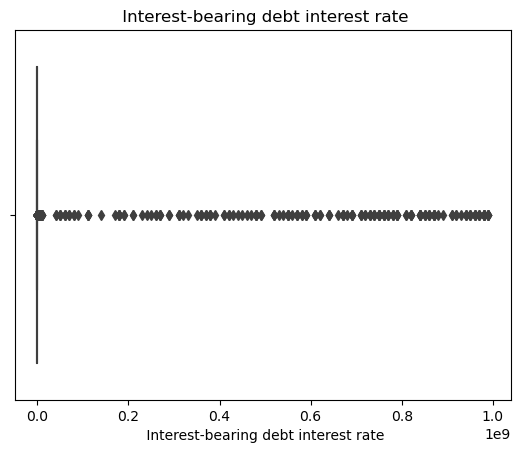

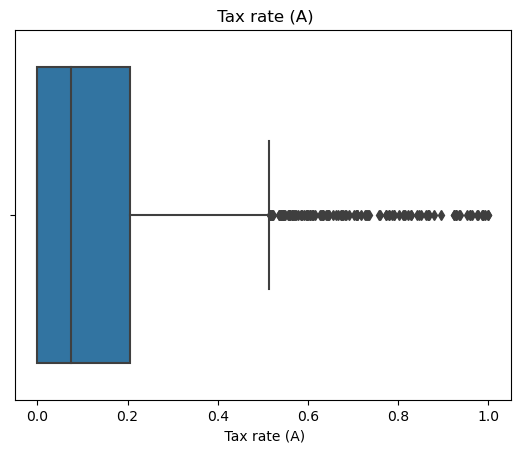

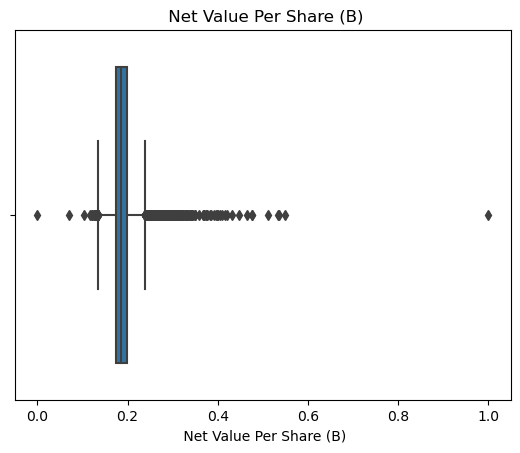

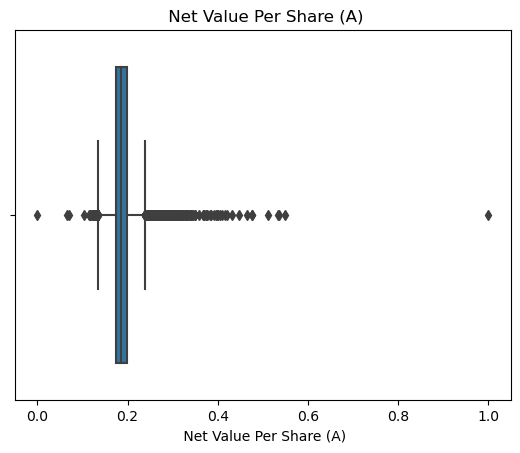

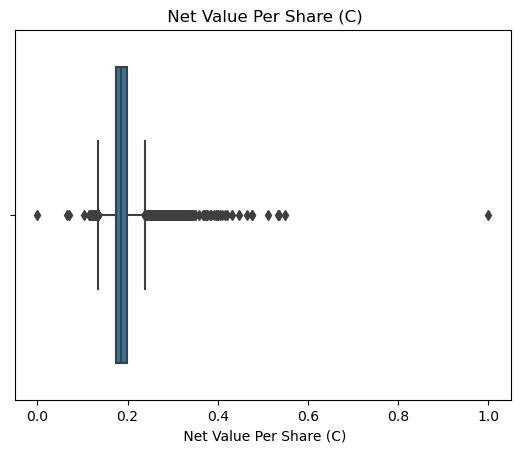

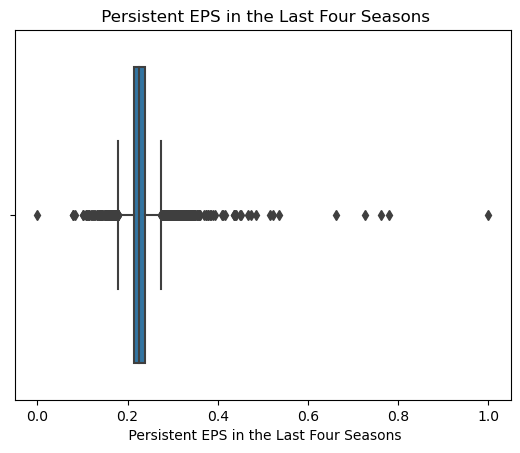

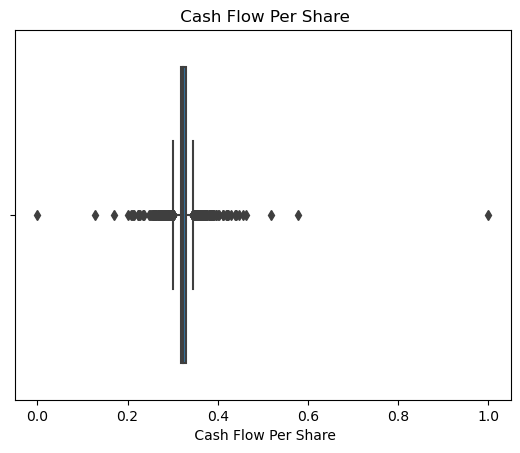

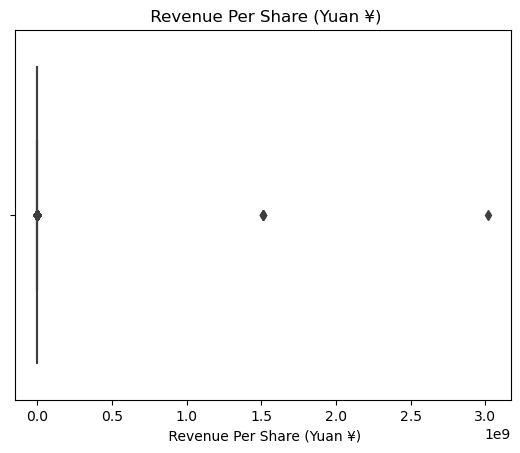

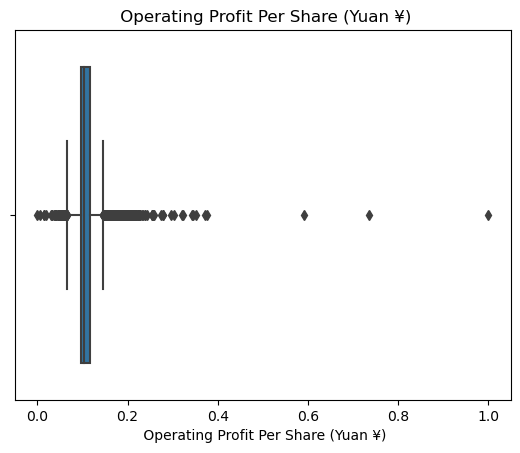

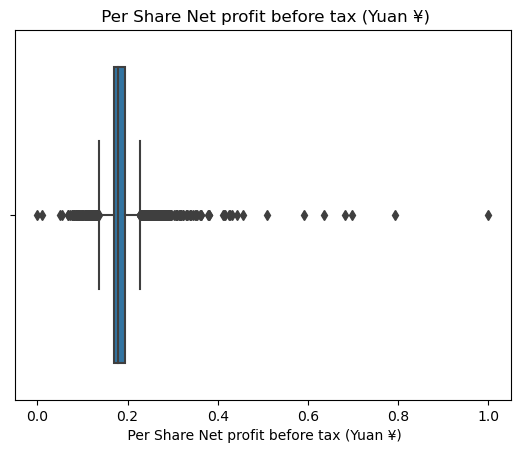

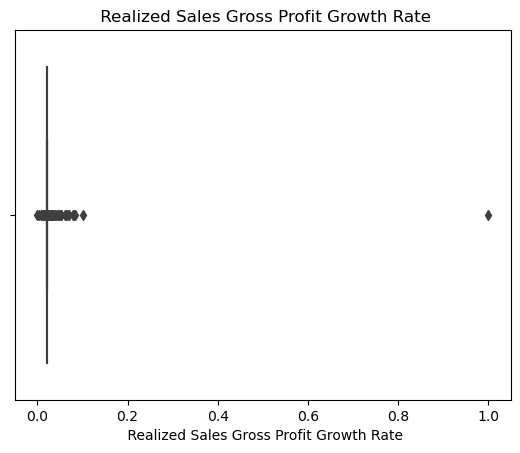

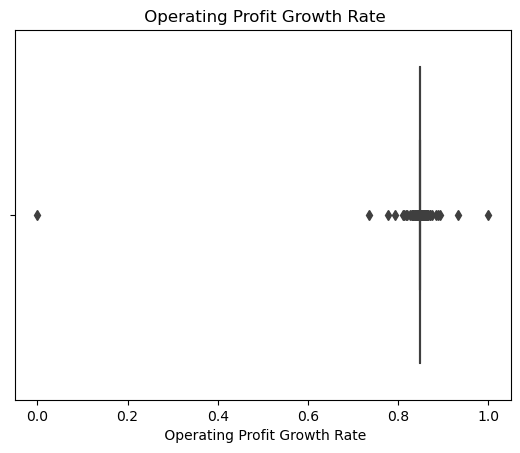

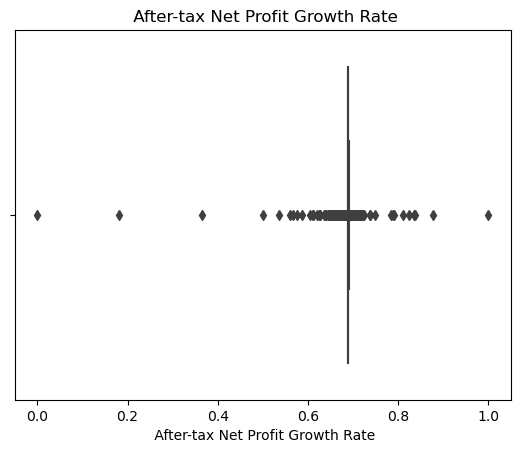

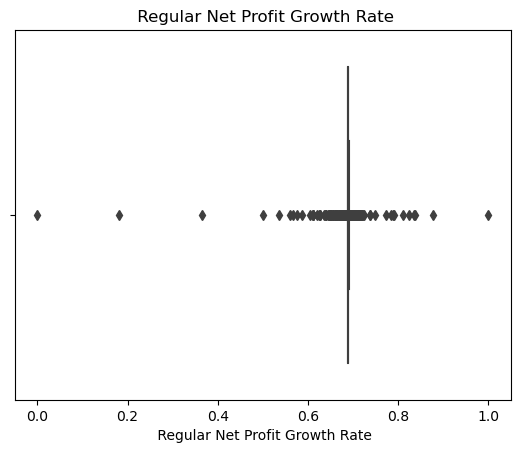

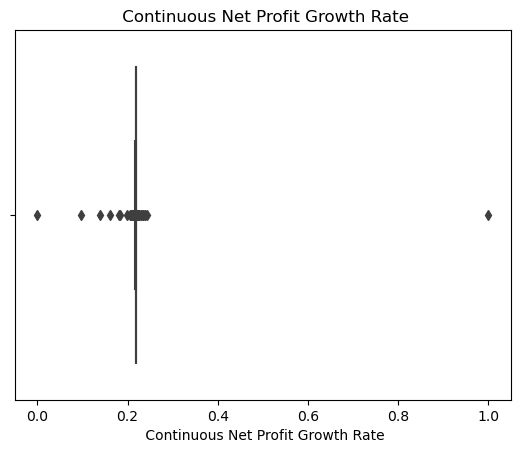

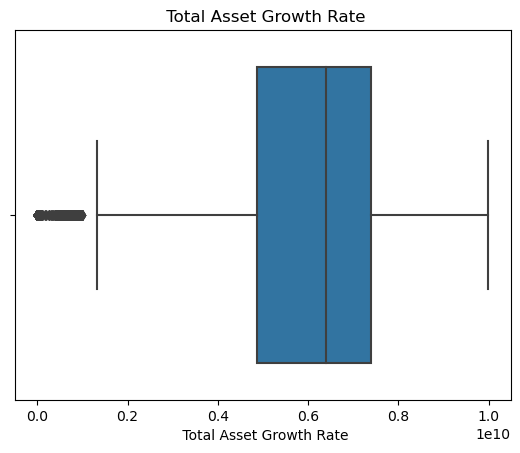

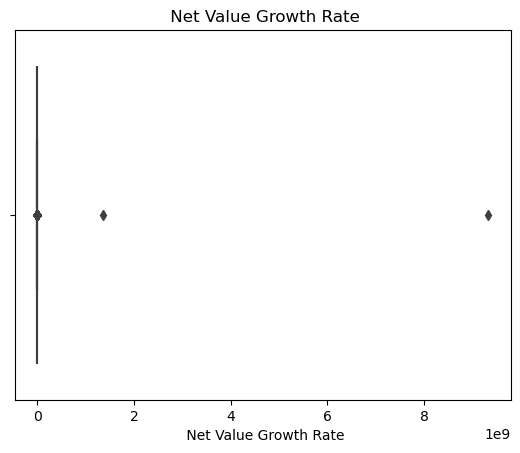

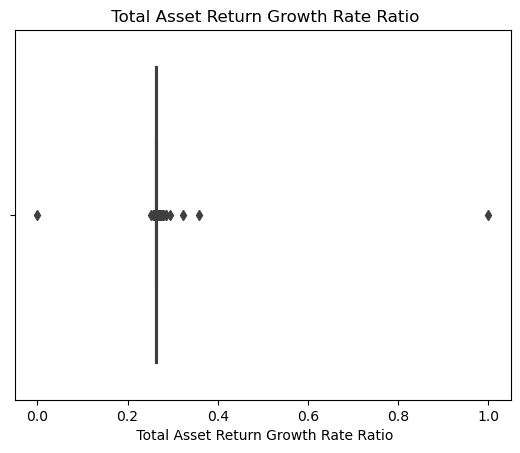

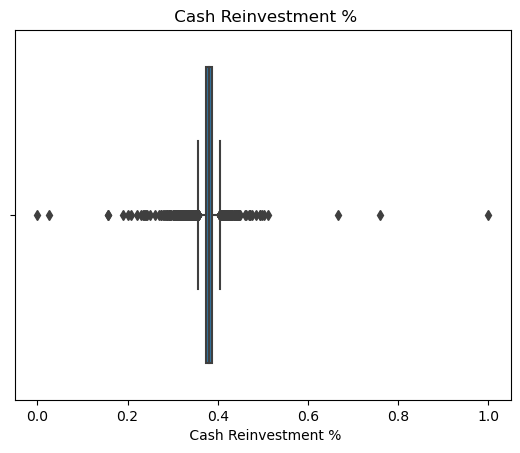

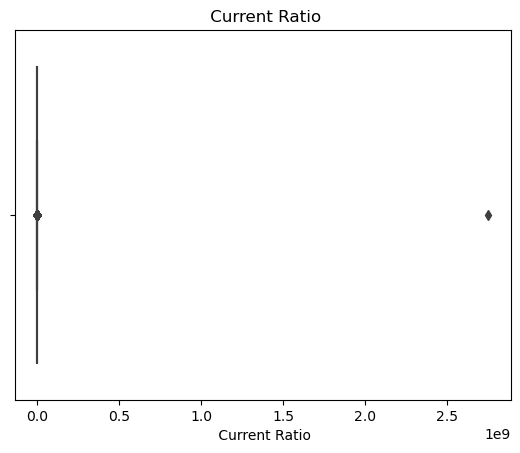

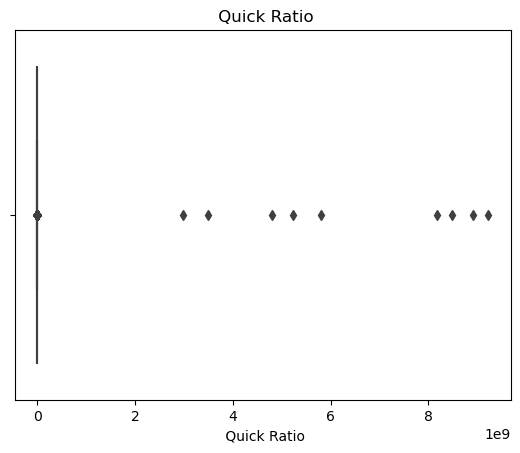

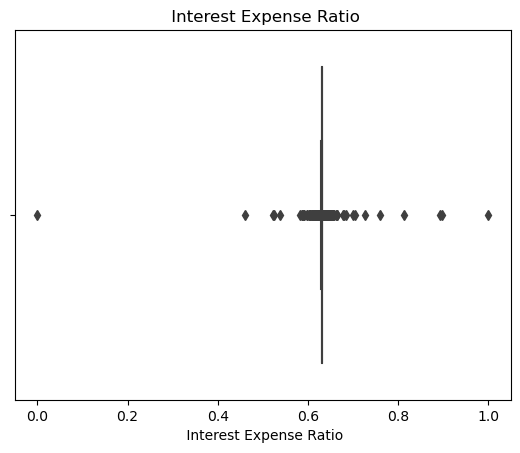

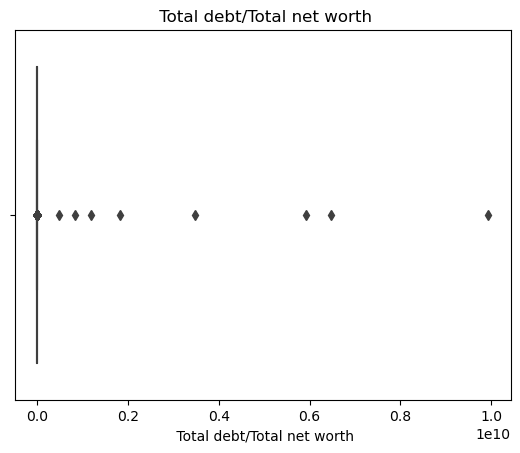

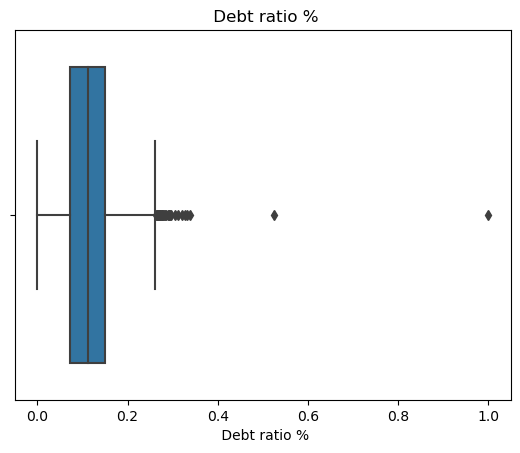

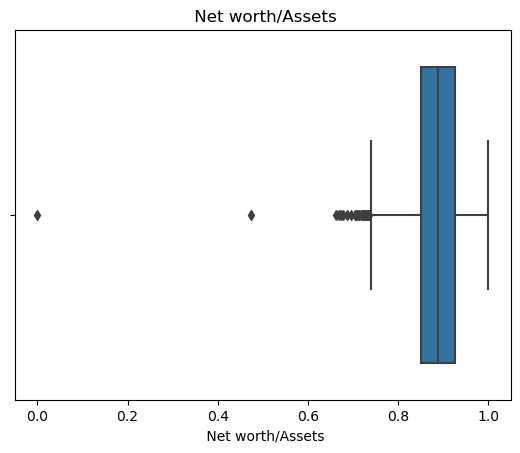

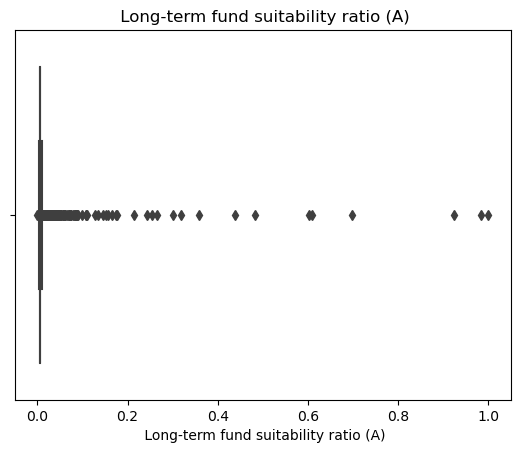

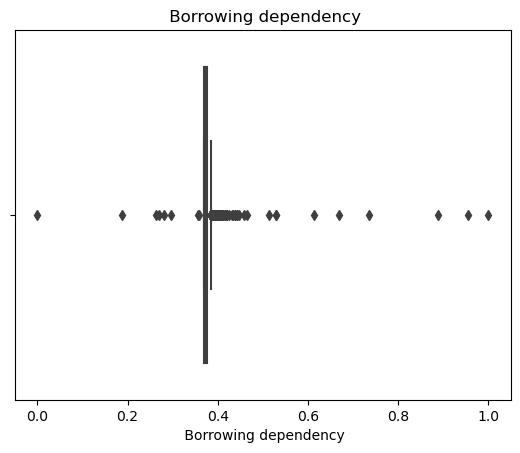

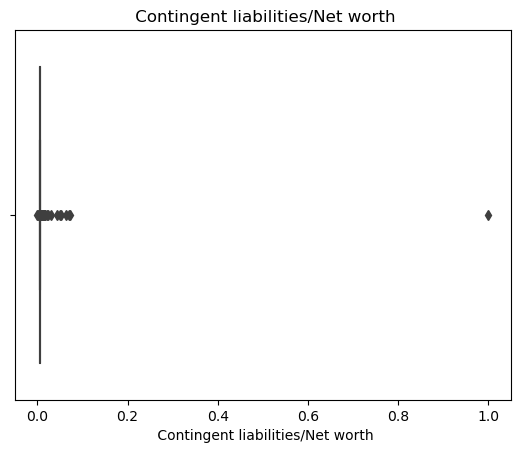

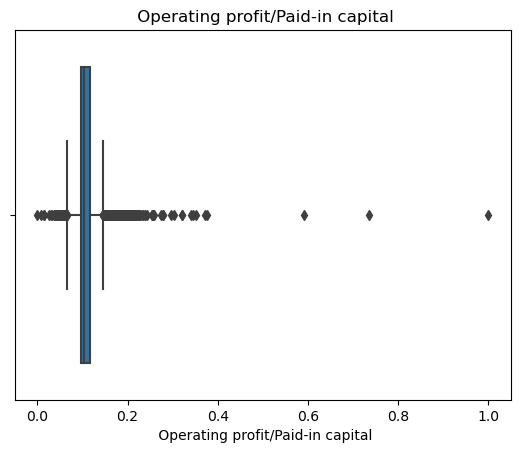

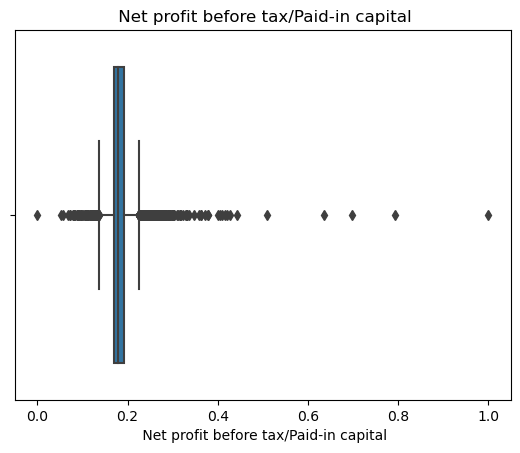

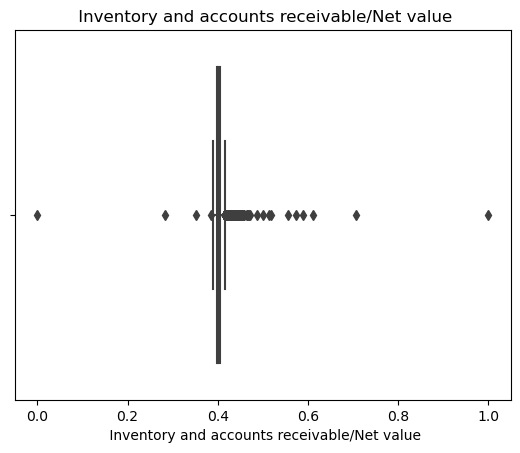

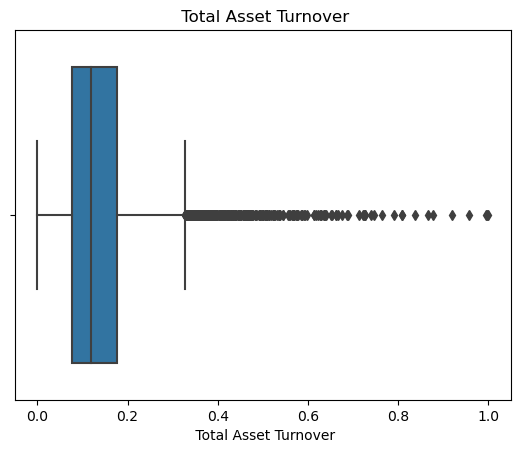

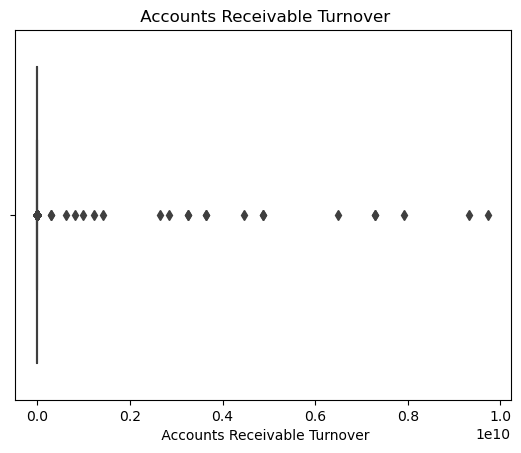

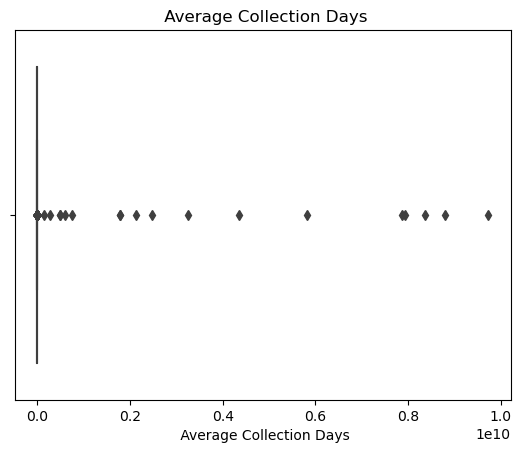

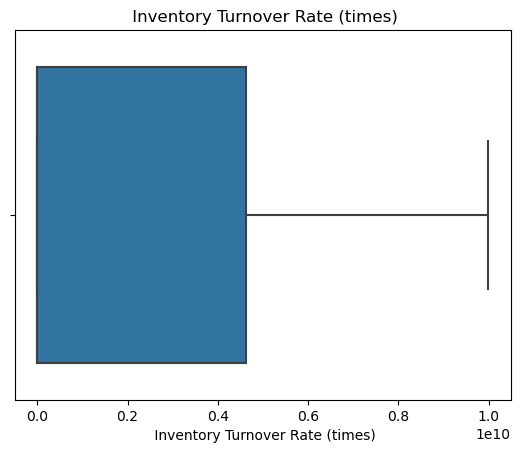

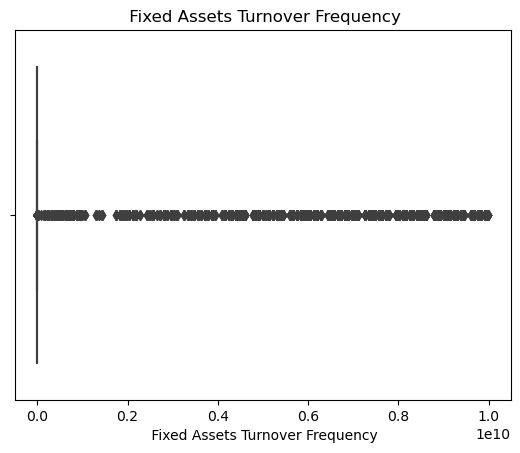

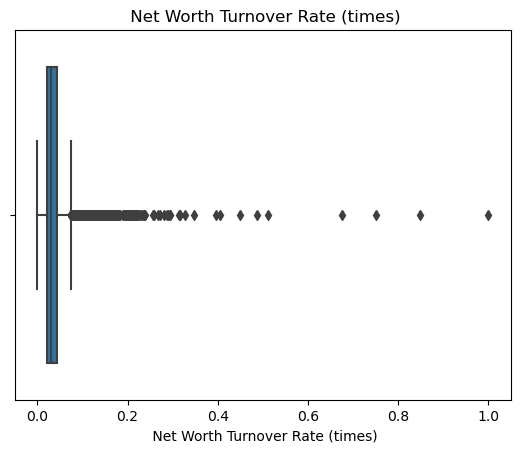

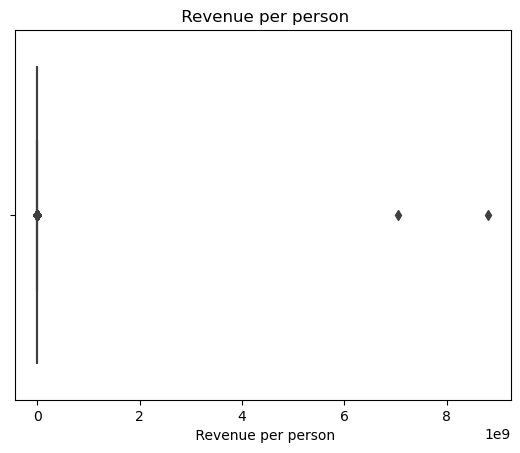

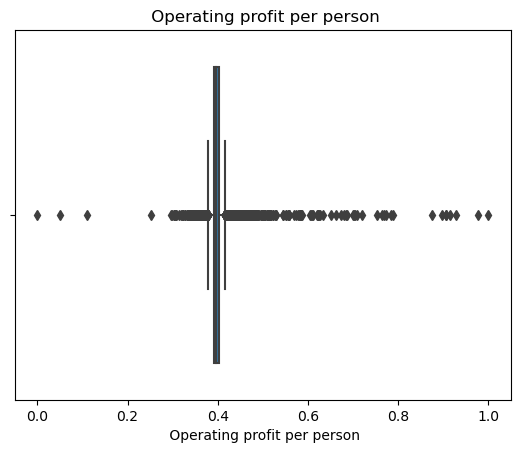

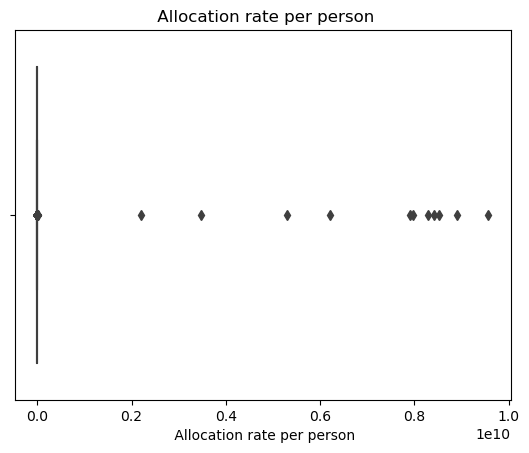

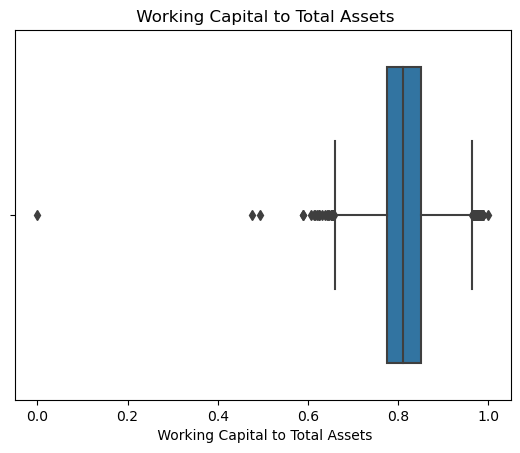

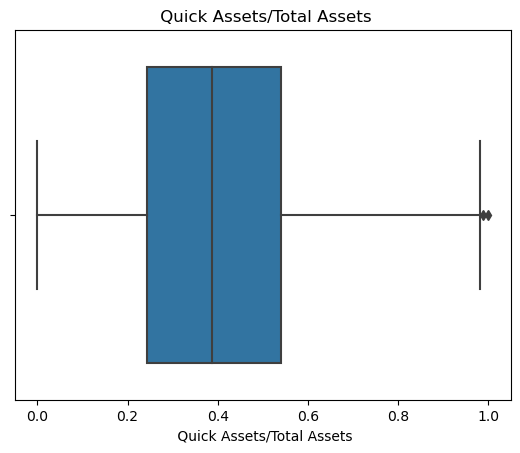

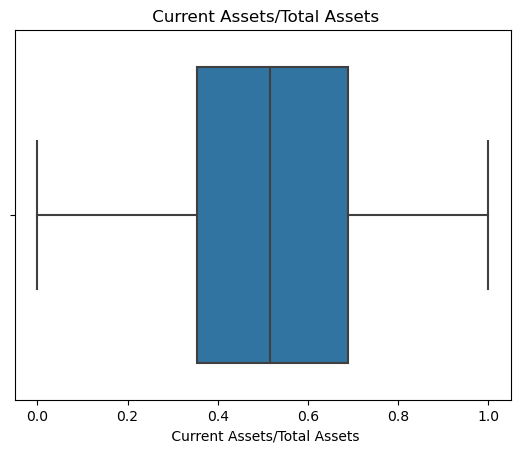

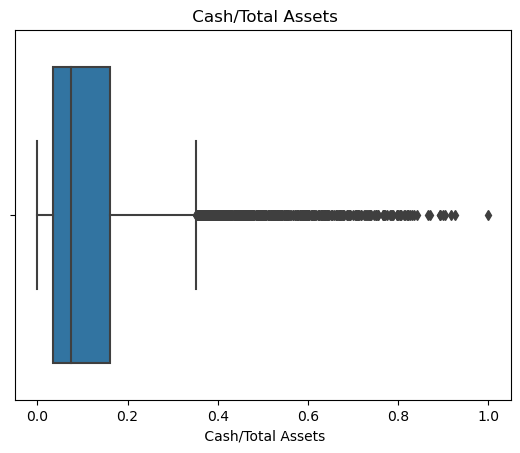

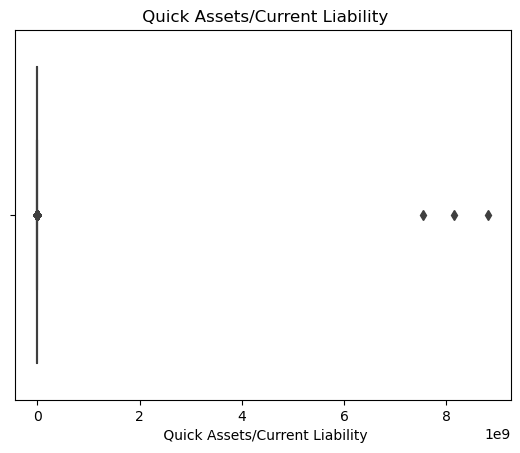

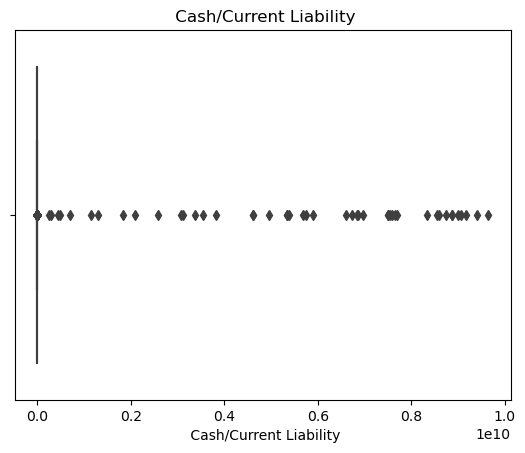

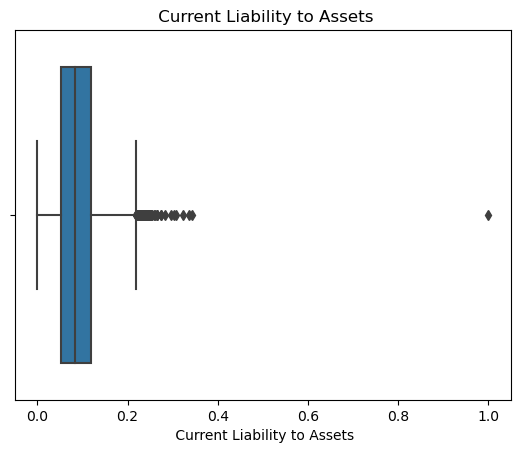

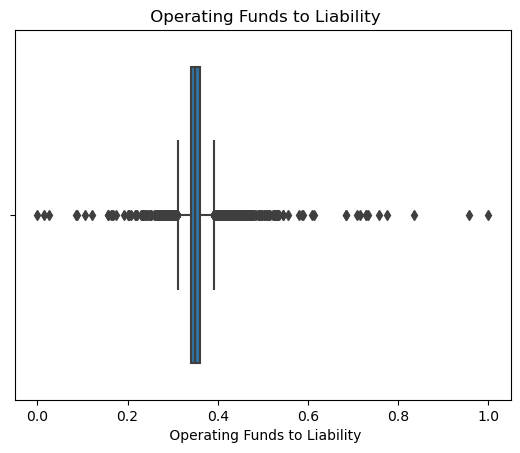

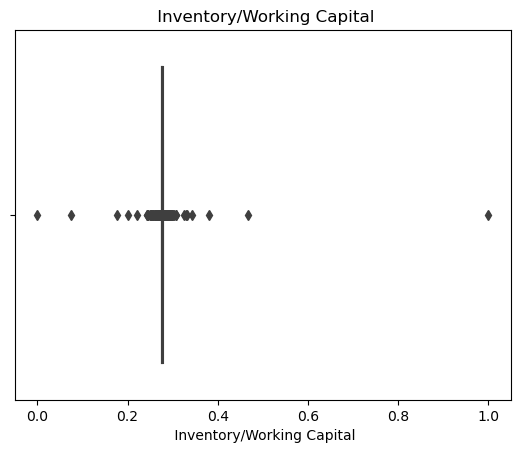

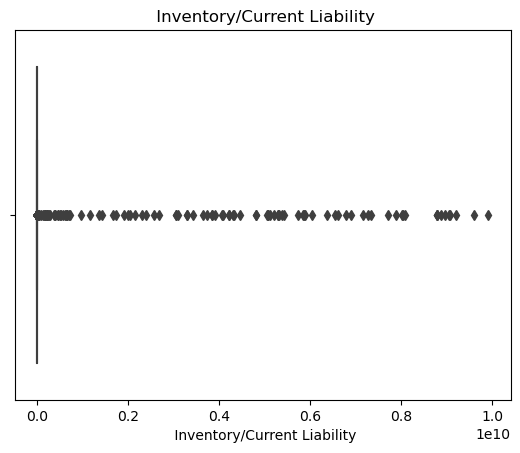

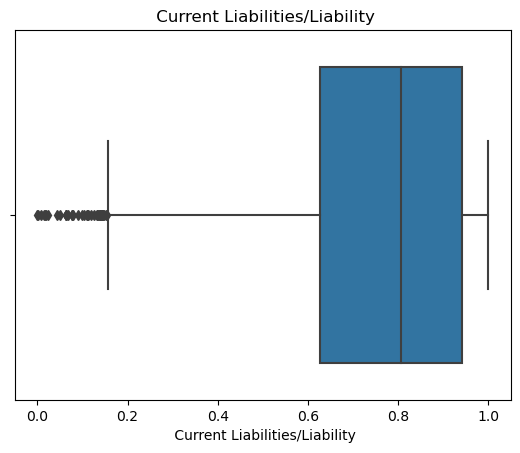

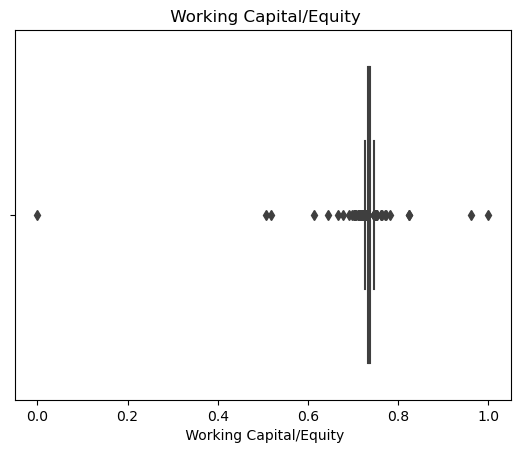

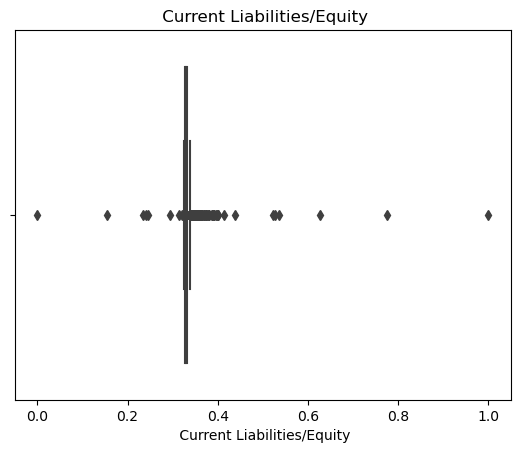

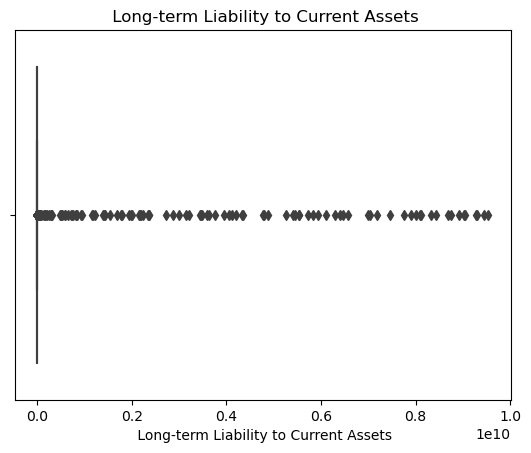

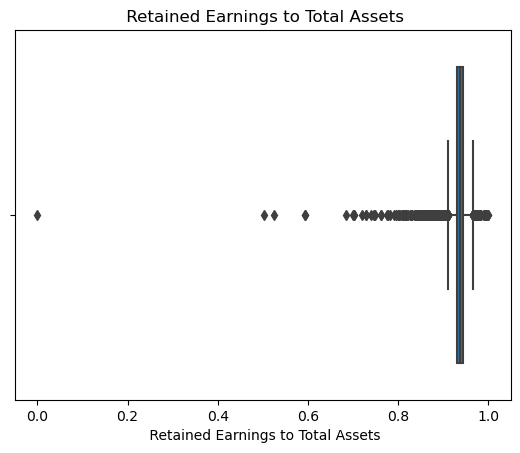

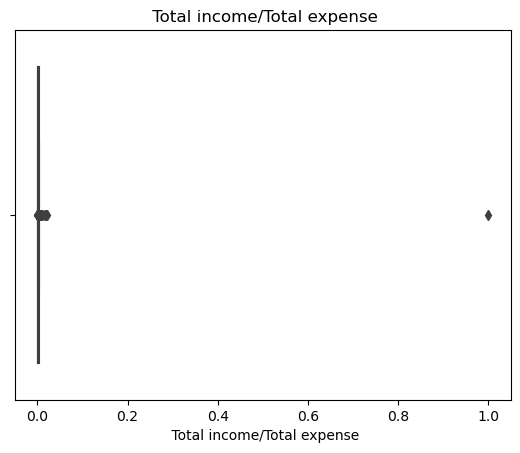

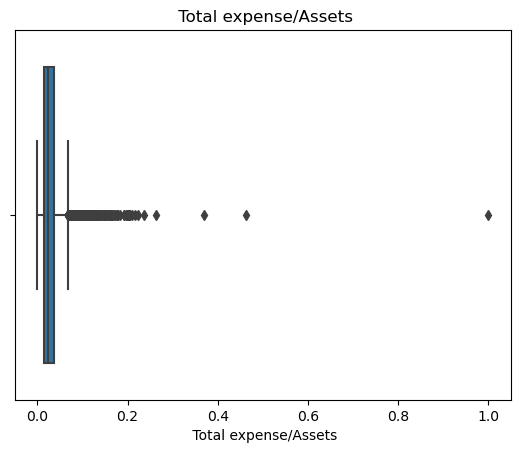

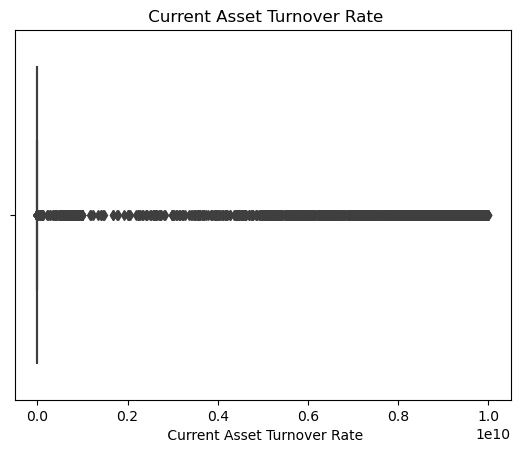

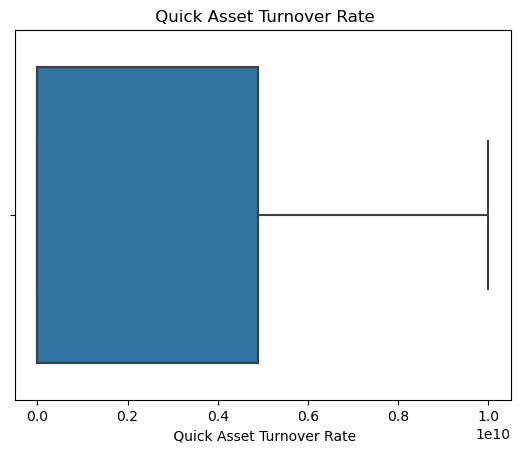

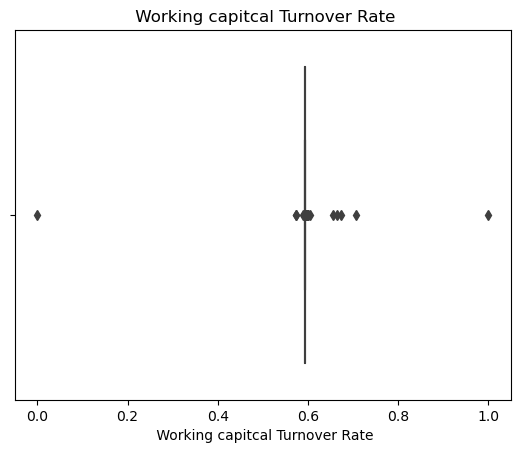

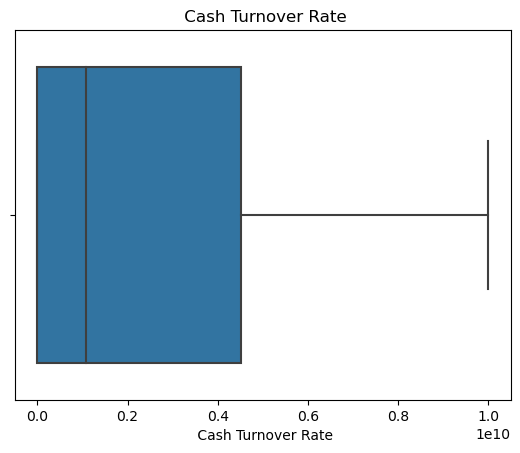

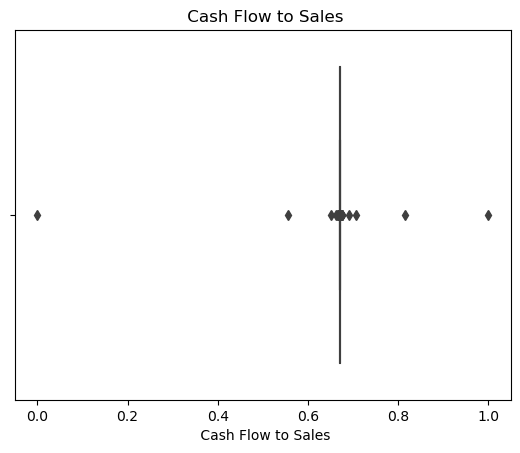

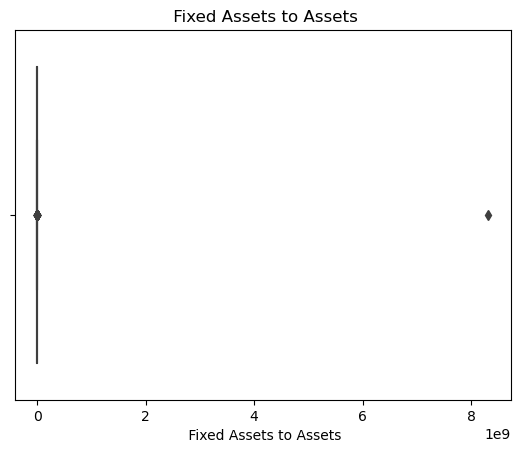

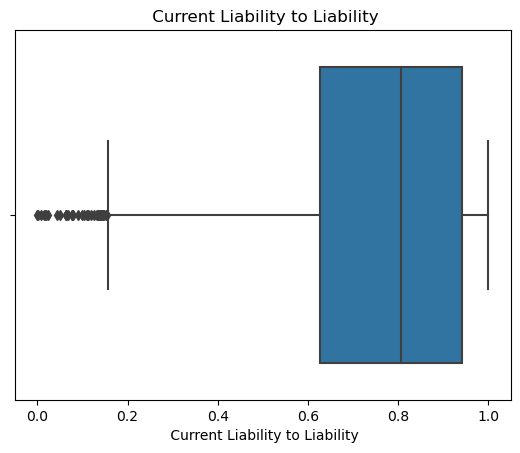

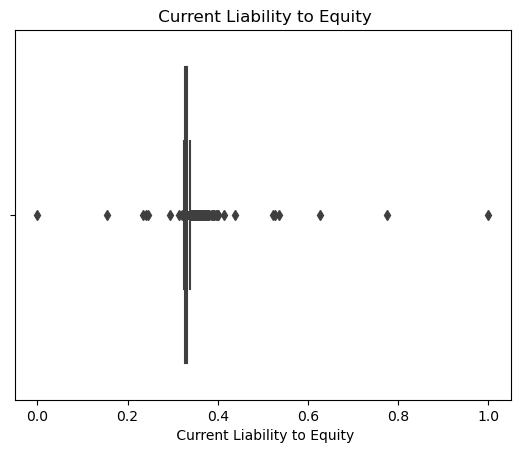

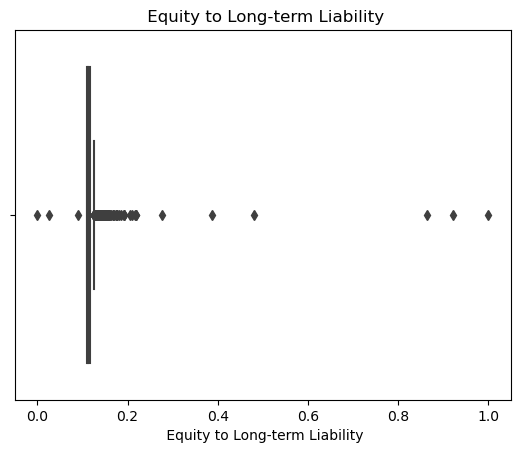

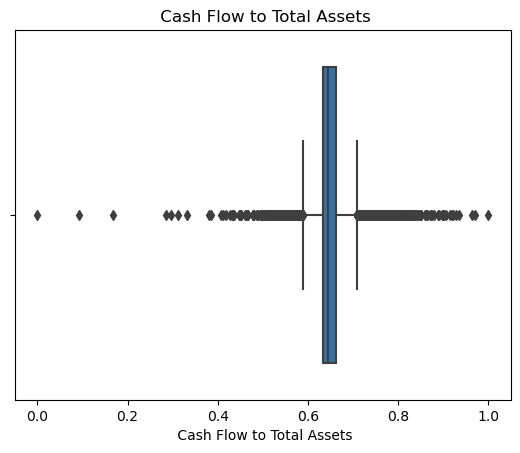

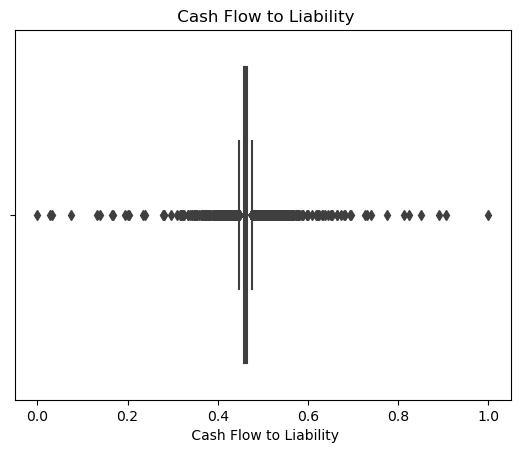

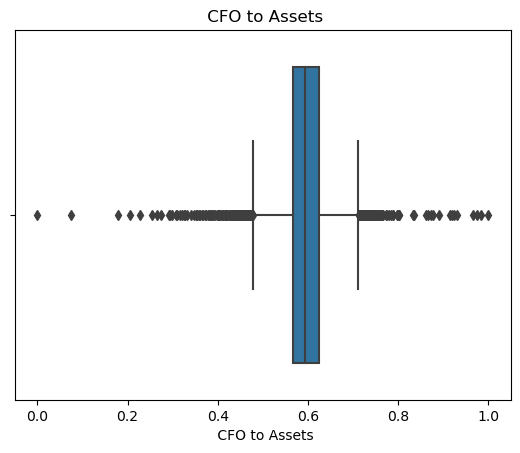

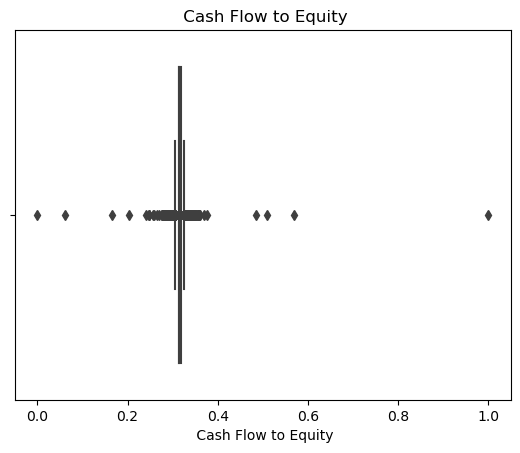

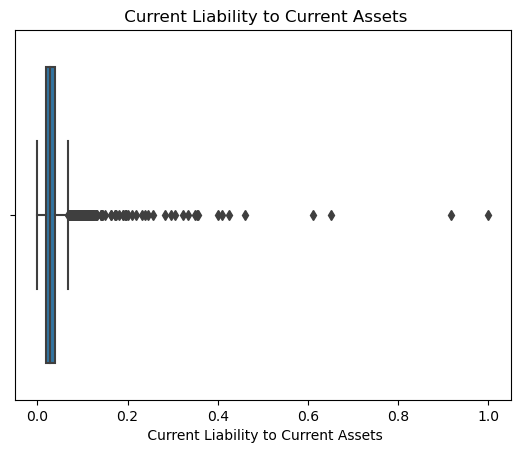

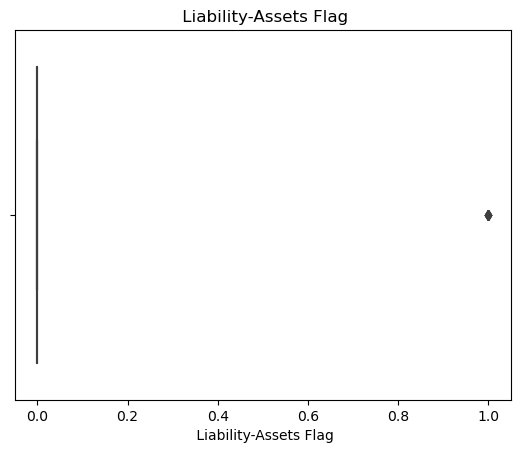

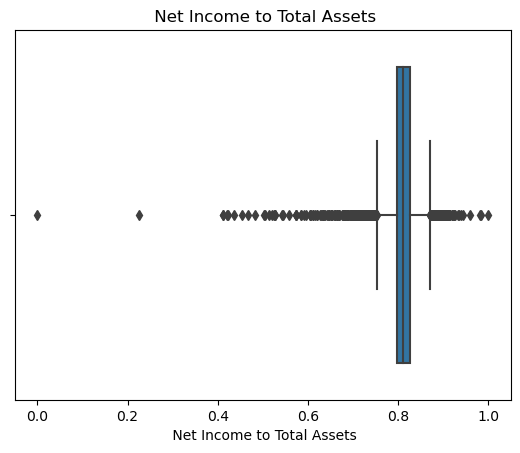

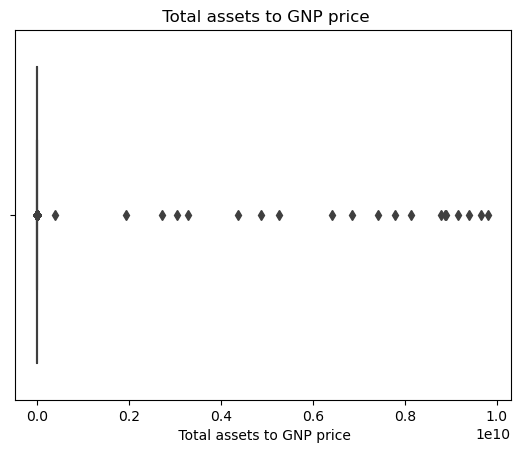

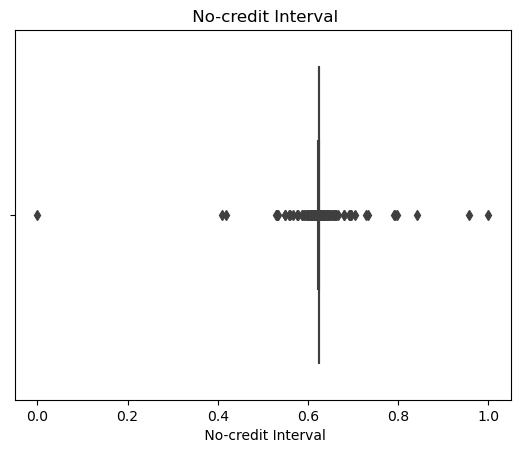

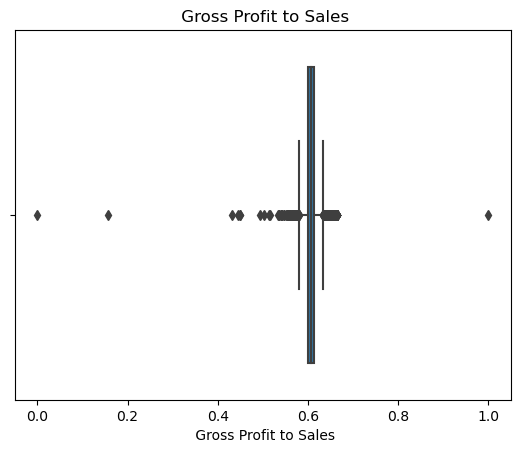

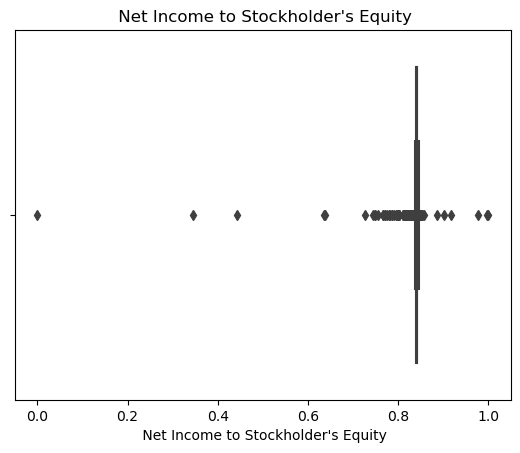

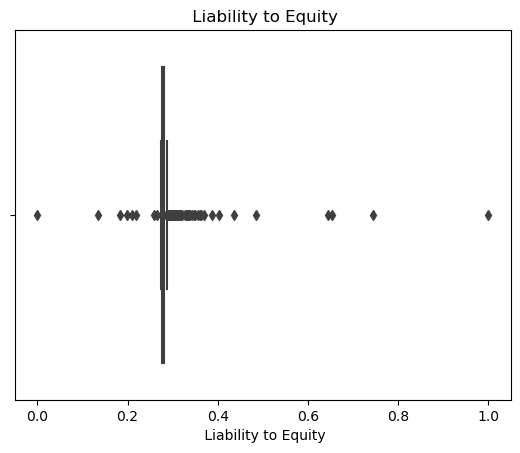

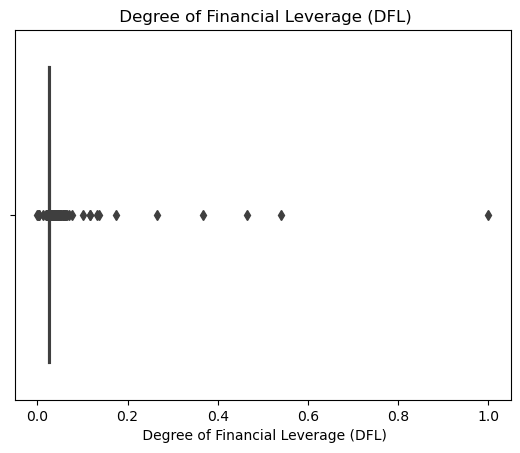

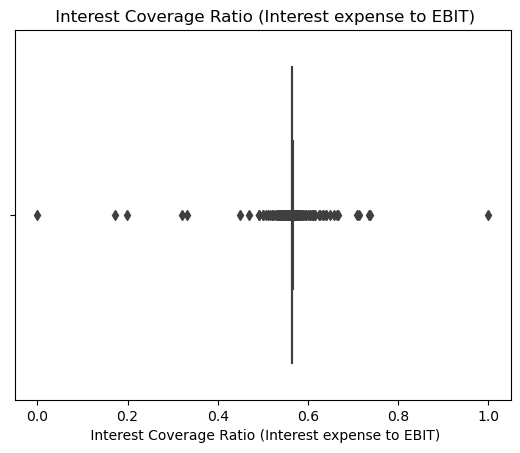

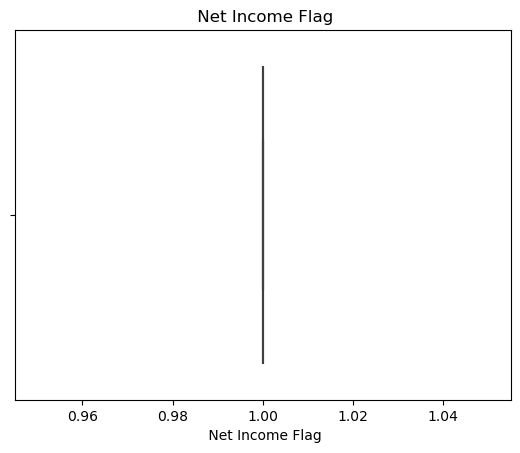

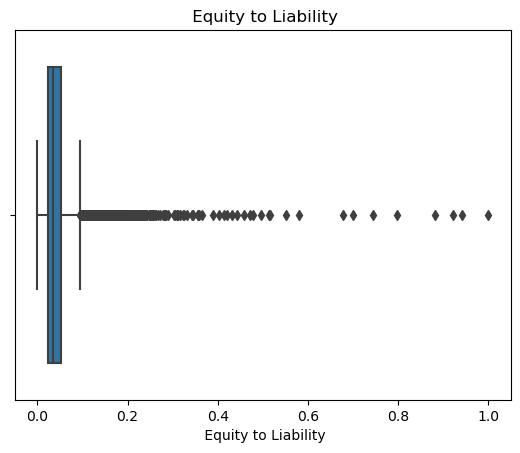

In [12]:
# Display Vars

for col in df.columns:
    
    # Show label counts.
    if col == "bankrupt":
        ax = sns.barplot()
        sns.countplot(x = df[col], ax = ax).set(title = col)
        plt.show()
        plt.close()
    
    else:
        # Display Full Boxplot
        ax = sns.boxplot(x = df[col]).set(title = col)
        plt.show()
        plt.close()
    

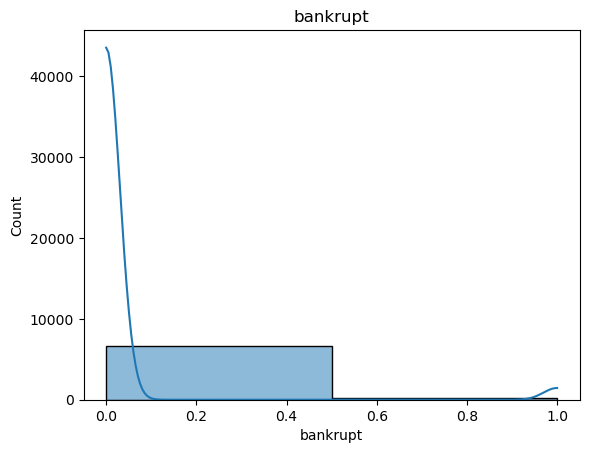

In [13]:
# Show histograms of each feature.

for col in df.columns:
    
    # Set plot.
    fig, ax = plt.subplots()
    
    # Set number of bins.
    if df[col].nunique() >= 5:
        
        bins = 5
    
    else:
    
        bins = df[col].nunique()
        
    sns.histplot(x = df[col], bins = bins, kde = True).set(title = col)
    
    
    plt.show()
    plt.close()

    break
    

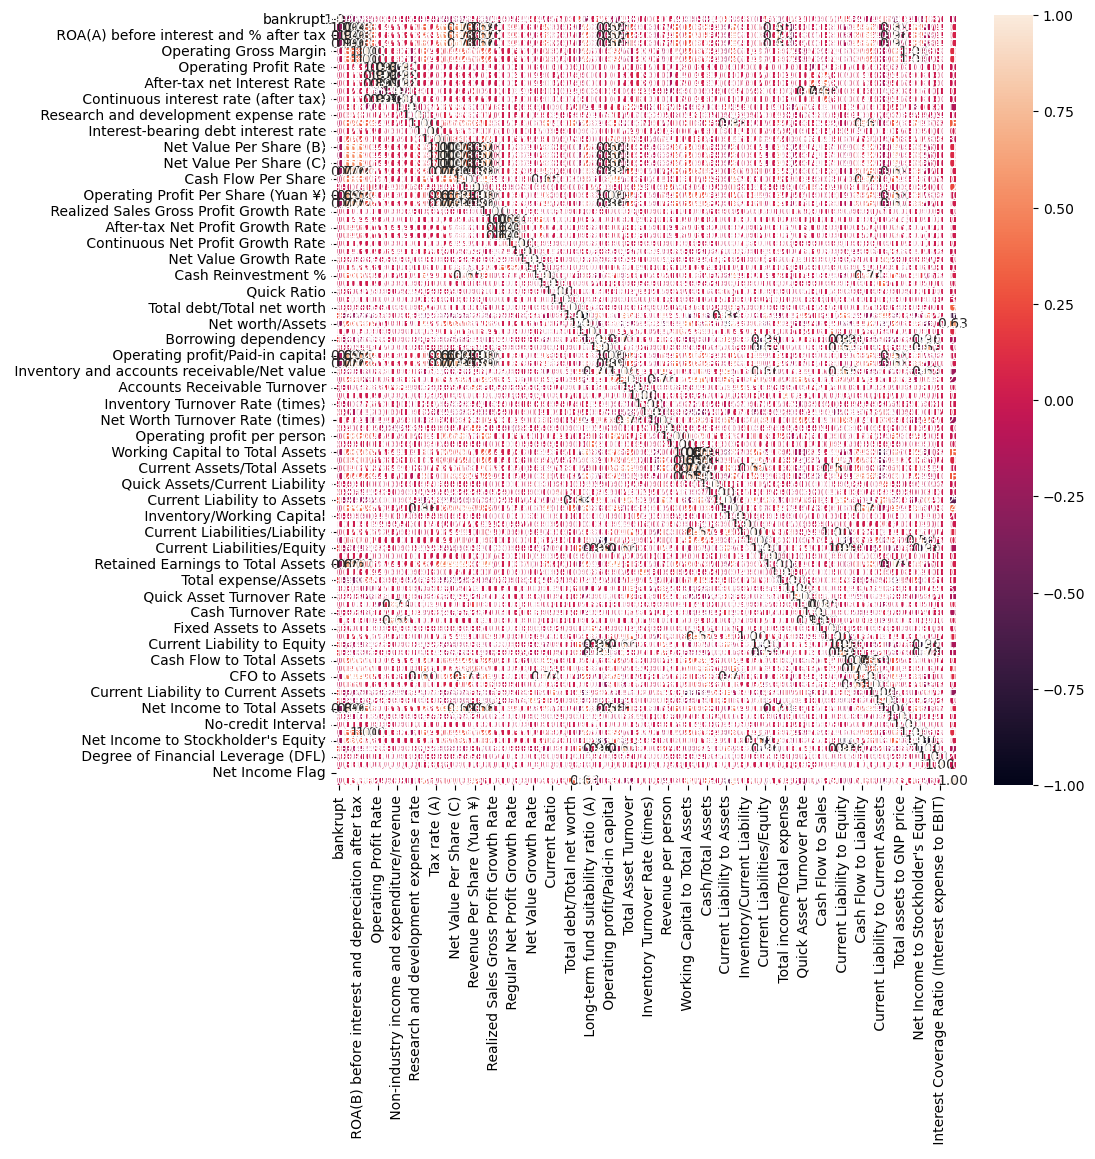

In [14]:
# Build Correlation Matrix

fig, axis = plt.subplots(figsize = (10, 10))
corr_mat = df[1:].corr()
sns.heatmap(corr_mat, annot = True, linewidth = 0.5, fmt = '.2f', ax = axis)
plt.show()


In [15]:
# Find highly Correlated Features
df_corr_features = pd.DataFrame(columns = ['feature_1', 'feature_2', 'corr_val'])

# Set correlation threshold.
corr_thresh = 0.5


# Find Correlated Features
# Iterate row.
for i in range(corr_mat.shape[0]):
    #Iterate column.
    for j in range(corr_mat.shape[1]):
        
        # Skip Self Correlation
        if corr_mat.index[i] == corr_mat.columns[j]:
            continue
            
        # Check for threshold value.
        val = corr_mat.iloc[i,j]
        if val >= corr_thresh:
            df_corr_features.loc[len(df_corr_features.index)] = [corr_mat.index[i], corr_mat.columns[j], val]
            

In [16]:
# Display Correlated Features

for feature in df_corr_features['feature_1']:
    df_temp = df_corr_features[df_corr_features['feature_1'] == feature]
    print(feature, "\n", df_temp[['feature_2','corr_val']], "\n\n")


 ROA(C) before interest and depreciation before interest 
                                             feature_2  corr_val
0              ROA(A) before interest and % after tax  0.940086
1    ROA(B) before interest and depreciation after...  0.986842
2                             Net Value Per Share (B)  0.505407
3                             Net Value Per Share (A)  0.505234
4                             Net Value Per Share (C)  0.505108
5             Persistent EPS in the Last Four Seasons  0.774885
6                 Operating Profit Per Share (Yuan ¥)  0.687307
7            Per Share Net profit before tax (Yuan ¥)  0.750491
8                    Operating profit/Paid-in capital  0.685134
9               Net profit before tax/Paid-in capital  0.753253
10                  Retained Earnings to Total Assets  0.650123
11                                      CFO to Assets  0.504145
12                         Net Income to Total Assets  0.887587 


 ROA(C) before interest and depreciation b

# Observations

Many features are highly correlated.  However, no features are highly correlated with our predictive label 'bankrupt.'


In [17]:
# Create dataframes to hold each classifier's metrics on each K-Fold Iteration.

df_random_forest_metrics = metrics_df()
df_random_forest_metrics.name = "Random Forest"

df_deep_learning_metrics = metrics_df()
df_deep_learning_metrics.name = "Deep Learning"

df_knn_metrics = metrics_df()
df_knn_metrics.name = "KNN"


In [18]:
# Split data from labels. y is labels, x is features.

labels = df.bankrupt
features = df.drop(columns = ['bankrupt'])


In [19]:
# Split dataset into test, train.

kf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
  

In [20]:
# Iterate folds.

for fold, (train_index, test_index) in enumerate(kf.split(features, labels), start = 1):
    
    # Random Forest
    df_random_forest_metrics.loc[len(df_random_forest_metrics)] = random_forest(train_index, test_index).values[0]
    
    # Deep Learning
    df_deep_learning_metrics.loc[len(df_deep_learning_metrics)] = deep_learning(train_index, test_index).values[0]
    
    # KNN
    df_knn_metrics.loc[len(df_knn_metrics)] = knn(train_index, test_index).values[0]


Random Forest Accuracy: 0.967741935483871


2024-04-21 16:32:41.388431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-21 16:32:41.388658: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9261 - loss: 9770014.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9437 - loss: 4602080.5000
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9386 - loss: 843170.8125
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9188 - loss: 415292.3438
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9465 - loss: 129570.2891
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9535 - loss: 220635.1562
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9409 - loss: 346045.0312
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9460 - loss: 96988.5781
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9352 - loss: 135880.0156
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9406 - loss: 71924.2188
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9375 - loss

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9189 - loss: 20387362.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9386 - loss: 4378139.5000
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9364 - loss: 3800196.2500
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9345 - loss: 1568474.8750
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9283 - loss: 1036715.0000
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9438 - loss: 384910.0312
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9472 - loss: 125005.8125
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9307 - loss: 565874.1875
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9427 - loss: 131935.8594
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9360 - loss: 108145.0703
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9328 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7087 - loss: 8403161.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8947 - loss: 15104263.0000
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9064 - loss: 384554.6562
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9158 - loss: 296098.0938
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9225 - loss: 187745.5312
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9258 - loss: 421769.1250
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9392 - loss: 99205.7266
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9228 - loss: 182442.2812
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9196 - loss: 183694.3594
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9350 - loss: 183528.9688
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9282 - lo

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6857 - loss: 64381020.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9158 - loss: 1350612.5000
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9389 - loss: 532588.9375
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9383 - loss: 1574485.8750
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9260 - loss: 467035.0000
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9263 - loss: 215833.8281
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9449 - loss: 108658.1953
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9345 - loss: 347054.8125
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9376 - loss: 122010.6250
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9493 - loss: 136970.2344
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9402 - 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8525 - loss: 79888776.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9415 - loss: 2579950.2500
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9344 - loss: 3033776.7500
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9372 - loss: 2948456.2500
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9504 - loss: 541543.8750
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9440 - loss: 514230.5000
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9462 - loss: 134810.5469
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9417 - loss: 184262.2031
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9387 - loss: 188583.8750
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9402 - loss: 119754.0000
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9468 -

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8409 - loss: 25470506.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9421 - loss: 19308092.0000
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9270 - loss: 3746394.2500
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9202 - loss: 2358720.0000
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9361 - loss: 1907142.3750
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9346 - loss: 2919891.7500
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9342 - loss: 2297124.0000
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9367 - loss: 1590207.6250
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9348 - loss: 1592742.6250
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9368 - loss: 1117664.5000
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8815 - loss: 17149496.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9502 - loss: 5846893.5000
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9367 - loss: 3461452.7500
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9376 - loss: 2831405.7500
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9406 - loss: 1671512.5000
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9415 - loss: 795658.6875
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9363 - loss: 896521.1250
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9170 - loss: 781399.6250
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9167 - loss: 3666245.0000
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9395 - loss: 1469161.0000
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.939

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7164 - loss: 45734276.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9293 - loss: 1399078.1250
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9258 - loss: 1810401.5000
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9300 - loss: 708951.3750
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9390 - loss: 391511.8438
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9433 - loss: 448230.4375
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9325 - loss: 341711.5625
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9349 - loss: 727591.5000
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9383 - loss: 274362.9375
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9388 - loss: 1035289.5000
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9309 -

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (6137, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6137, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6258 - loss: 6819023.5000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9194 - loss: 1719714.8750
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9269 - loss: 814273.7500
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9354 - loss: 415250.5312
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9263 - loss: 369108.8438
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9188 - loss: 309395.2500
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9390 - loss: 270075.0312
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9351 - loss: 183540.3750
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9452 - loss: 215427.8281
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9491 - loss: 126734.6875
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9307 - lo

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (6138, 90)             │        33,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_layer (Dense)            │ (6138, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,211 (129.73 KB)

 Trainable params: 33,211 (129.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7836 - loss: 22869332.0000
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9376 - loss: 5224322.0000
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9312 - loss: 3768215.5000
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9459 - loss: 1914247.8750
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9485 - loss: 610488.6250
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9427 - loss: 220358.8750
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9494 - loss: 94944.6406
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9418 - loss: 95163.9062
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9432 - loss: 82674.4219
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9460 - loss: 81254.0078
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9278 - los

In [21]:
# Store all metrics dataframes.

classifier_metrics = (df_random_forest_metrics, df_deep_learning_metrics, df_knn_metrics)


In [22]:
for classifier in classifier_metrics:
    
    #Average over all folds.
    classifier.loc[len(classifier)] = classifier.mean().round(2)
    
    # Change index to list "avg."
    if not 'avg' in classifier.index.tolist():

        mut_index = classifier.index.tolist()
        mut_index[-1] = "avg"
        classifier.index = mut_index



In [23]:
df_random_forest_metrics.T


0           1           2           3           4           5  \
FP      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
FN     22.000000   22.000000   22.000000   22.000000   22.000000   22.000000   
TP    660.000000  660.000000  660.000000  660.000000  660.000000  660.000000   
TN      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
P     682.000000  682.000000  682.000000  682.000000  682.000000  682.000000   
N       0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
TPR     0.967742    0.967742    0.967742    0.967742    0.967742    0.967742   
TNR     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
FPR     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
FNR     0.032258    0.032258    0.032258    0.032258    0.032258    0.032258   
r       0.967742    0.967742    0.967742    0.967742    0.967742    0.967742   
PPV     1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
f1      0.983607    0.983607    0.983607    0.983607    0.983607    0.983607   
NPV     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
FDR     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
ACC     0.967742    0.967742    0.967742    0.967742    0.967742    0.967742   
BACC    0.483871    0.483871    0.483871    0.483871    0.483871    0.483871   
TSS     0.967742    0.967742    0.967742    0.967742    0.967742    0.967742   
HSS     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

               6           7           8           9     avg  
FP      0.000000    0.000000    0.000000    0.000000    0.00  
FN     22.000000   22.000000   22.000000   22.000000   22.00  
TP    660.000000  660.000000  660.000000  659.000000  659.90  
TN      0.000000    0.000000    0.000000    0.000000    0.00  
P     682.000000  682.000000  682.000000  681.000000  681.90  
N       0.000000    0.000000    0.000000    0.000000    0.00  
TPR     0.967742    0.967742    0.967742    0.967695    0.97  
TNR     0.000000    0.000000    0.000000    0.000000    0.00  
FPR     0.000000    0.000000    0.000000    0.000000    0.00  
FNR     0.032258    0.032258    0.032258    0.032305    0.03  
r       0.967742    0.967742    0.967742    0.967695    0.97  
PPV     1.000000    1.000000    1.000000    1.000000    1.00  
f1      0.983607    0.983607    0.983607    0.983582    0.98  
NPV     0.000000    0.000000    0.000000    0.000000    0.00  
FDR     0.000000    0.000000    0.000000    0.000000    0.00  
ACC     0.967742    0.967742    0.967742    0.967695    0.97  
BACC    0.483871    0.483871    0.483871    0.483847    0.48  
TSS     0.967742    0.967742    0.967742    0.967695    0.97  
HSS     0.000000    0.000000    0.000000    0.000000    0.00

In [24]:
df_random_forest_metrics.T['avg']


FP        0.00
FN       22.00
TP      659.90
TN        0.00
P       681.90
N         0.00
TPR       0.97
TNR       0.00
FPR       0.00
FNR       0.03
r         0.97
PPV       1.00
f1        0.98
NPV       0.00
FDR       0.00
ACC       0.97
BACC      0.48
TSS       0.97
HSS       0.00
Name: avg, dtype: float64

In [25]:
df_deep_learning_metrics.T


0           1           2           3           4           5  \
FP      4.000000    0.000000   17.000000   32.000000    0.000000  184.000000   
FN     22.000000   22.000000   19.000000   19.000000   22.000000   13.000000   
TP    656.000000  660.000000  643.000000  628.000000  660.000000  476.000000   
TN      0.000000    0.000000    3.000000    3.000000    0.000000    9.000000   
P     678.000000  682.000000  662.000000  647.000000  682.000000  489.000000   
N       4.000000    0.000000   20.000000   35.000000    0.000000  193.000000   
TPR     0.967552    0.967742    0.971299    0.970634    0.967742    0.973415   
TNR     0.000000    0.000000    0.150000    0.085714    0.000000    0.046632   
FPR     1.000000    0.000000    0.850000    0.914286    0.000000    0.953368   
FNR     0.032448    0.032258    0.028701    0.029366    0.032258    0.026585   
r       0.967552    0.967742    0.971299    0.970634    0.967742    0.973415   
PPV     0.993939    1.000000    0.974242    0.951515    1.000000    0.721212   
f1      0.980568    0.983607    0.972769    0.960979    0.983607    0.828547   
NPV     0.000000    0.000000    0.136364    0.136364    0.000000    0.409091   
FDR     0.006061    0.000000    0.025758    0.048485    0.000000    0.278788   
ACC     0.961877    0.967742    0.947214    0.925220    0.967742    0.711144   
BACC    0.483776    0.483871    0.560650    0.528174    0.483871    0.510024   
TSS    -0.032448    0.967742    0.121299    0.056348    0.967742    0.020047   
HSS    -0.000004    0.000000    0.000017    0.000008    0.000000    0.000003   

               6           7           8           9     avg  
FP      3.000000    0.000000   23.000000    0.000000   26.30  
FN     22.000000   22.000000   21.000000   22.000000   20.40  
TP    657.000000  660.000000  637.000000  659.000000  633.60  
TN      0.000000    0.000000    1.000000    0.000000    1.60  
P     679.000000  682.000000  658.000000  681.000000  654.00  
N       3.000000    0.000000   24.000000    0.000000   27.90  
TPR     0.967599    0.967742    0.968085    0.967695    0.97  
TNR     0.000000    0.000000    0.041667    0.000000    0.03  
FPR     1.000000    0.000000    0.958333    0.000000    0.57  
FNR     0.032401    0.032258    0.031915    0.032305    0.03  
r       0.967599    0.967742    0.968085    0.967695    0.97  
PPV     0.995455    1.000000    0.965152    1.000000    0.96  
f1      0.981329    0.983607    0.966616    0.983582    0.96  
NPV     0.000000    0.000000    0.045455    0.000000    0.07  
FDR     0.004545    0.000000    0.034848    0.000000    0.04  
ACC     0.963343    0.967742    0.935484    0.967695    0.93  
BACC    0.483800    0.483871    0.504876    0.483847    0.50  
TSS    -0.032401    0.967742    0.009752    0.967695    0.40  
HSS    -0.000004    0.000000    0.000001    0.000000    0.00

In [26]:
df_deep_learning_metrics.T['avg']


FP       26.30
FN       20.40
TP      633.60
TN        1.60
P       654.00
N        27.90
TPR       0.97
TNR       0.03
FPR       0.57
FNR       0.03
r         0.97
PPV       0.96
f1        0.96
NPV       0.07
FDR       0.04
ACC       0.93
BACC      0.50
TSS       0.40
HSS       0.00
Name: avg, dtype: float64

In [27]:
df_knn_metrics.T


0           1           2           3           4           5  \
FP      0.000000    3.000000    1.000000    0.000000    0.000000    1.000000   
FN     21.000000   22.000000   22.000000   20.000000   21.000000   22.000000   
TP    660.000000  657.000000  659.000000  660.000000  660.000000  659.000000   
TN      1.000000    0.000000    0.000000    2.000000    1.000000    0.000000   
P     681.000000  679.000000  681.000000  680.000000  681.000000  681.000000   
N       1.000000    3.000000    1.000000    2.000000    1.000000    1.000000   
TPR     0.969163    0.967599    0.967695    0.970588    0.969163    0.967695   
TNR     1.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
FPR     0.000000    1.000000    1.000000    0.000000    0.000000    1.000000   
FNR     0.030837    0.032401    0.032305    0.029412    0.030837    0.032305   
r       0.969163    0.967599    0.967695    0.970588    0.969163    0.967695   
PPV     1.000000    0.995455    0.998485    1.000000    1.000000    0.998485   
f1      0.984340    0.981329    0.982849    0.985075    0.984340    0.982849   
NPV     0.045455    0.000000    0.000000    0.090909    0.045455    0.000000   
FDR     0.000000    0.004545    0.001515    0.000000    0.000000    0.001515   
ACC     0.969208    0.963343    0.966276    0.970674    0.969208    0.966276   
BACC    0.984581    0.483800    0.483847    0.985294    0.984581    0.483847   
TSS     0.969163   -0.032401   -0.032305    0.970588    0.969163   -0.032305   
HSS     0.000133   -0.000004   -0.000004    0.000134    0.000133   -0.000004   

               6           7           8           9     avg  
FP      2.000000    1.000000    1.000000    1.000000    1.00  
FN     22.000000   22.000000   22.000000   22.000000   21.60  
TP    658.000000  659.000000  659.000000  658.000000  658.90  
TN      0.000000    0.000000    0.000000    0.000000    0.40  
P     680.000000  681.000000  681.000000  680.000000  680.50  
N       2.000000    1.000000    1.000000    1.000000    1.40  
TPR     0.967647    0.967695    0.967695    0.967647    0.97  
TNR     0.000000    0.000000    0.000000    0.000000    0.30  
FPR     1.000000    1.000000    1.000000    1.000000    0.70  
FNR     0.032353    0.032305    0.032305    0.032353    0.03  
r       0.967647    0.967695    0.967695    0.967647    0.97  
PPV     0.996970    0.998485    0.998485    0.998483    1.00  
f1      0.982090    0.982849    0.982849    0.982823    0.98  
NPV     0.000000    0.000000    0.000000    0.000000    0.02  
FDR     0.003030    0.001515    0.001515    0.001517    0.00  
ACC     0.964809    0.966276    0.966276    0.966226    0.97  
BACC    0.483824    0.483847    0.483847    0.483824    0.63  
TSS    -0.032353   -0.032305   -0.032305   -0.032353    0.27  
HSS    -0.000004   -0.000004   -0.000004   -0.000004    0.00

In [28]:
df_knn_metrics.T['avg']


FP        1.00
FN       21.60
TP      658.90
TN        0.40
P       680.50
N         1.40
TPR       0.97
TNR       0.30
FPR       0.70
FNR       0.03
r         0.97
PPV       1.00
f1        0.98
NPV       0.02
FDR       0.00
ACC       0.97
BACC      0.63
TSS       0.27
HSS       0.00
Name: avg, dtype: float64

In [29]:
df_classifier_metrics_avg = pd.DataFrame(
    data = [df_random_forest_metrics.T['avg'],
            df_deep_learning_metrics.T['avg'],
            df_knn_metrics.T['avg']
    ],
    index = ['RandomForest','DeepLearning','KNN']

)


In [30]:
df_classifier_metrics_avg


FP    FN     TP   TN      P     N   TPR   TNR   FPR   FNR  \
RandomForest   0.0  22.0  659.9  0.0  681.9   0.0  0.97  0.00  0.00  0.03   
DeepLearning  26.3  20.4  633.6  1.6  654.0  27.9  0.97  0.03  0.57  0.03   
KNN            1.0  21.6  658.9  0.4  680.5   1.4  0.97  0.30  0.70  0.03   

                 r   PPV    f1   NPV   FDR   ACC  BACC   TSS  HSS  
RandomForest  0.97  1.00  0.98  0.00  0.00  0.97  0.48  0.97  0.0  
DeepLearning  0.97  0.96  0.96  0.07  0.04  0.93  0.50  0.40  0.0  
KNN           0.97  1.00  0.98  0.02  0.00  0.97  0.63  0.27  0.0

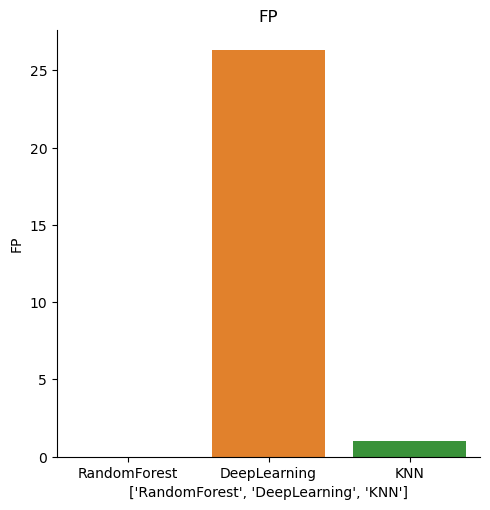

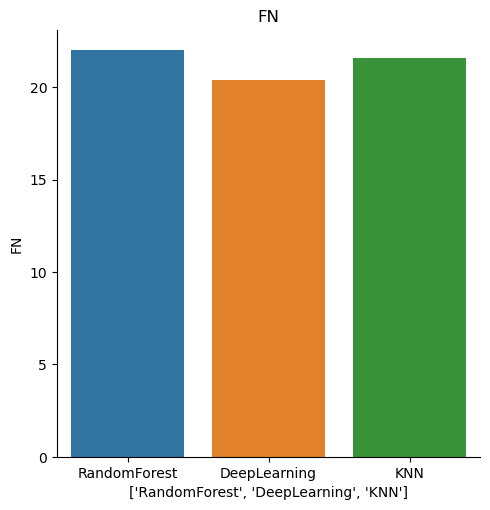

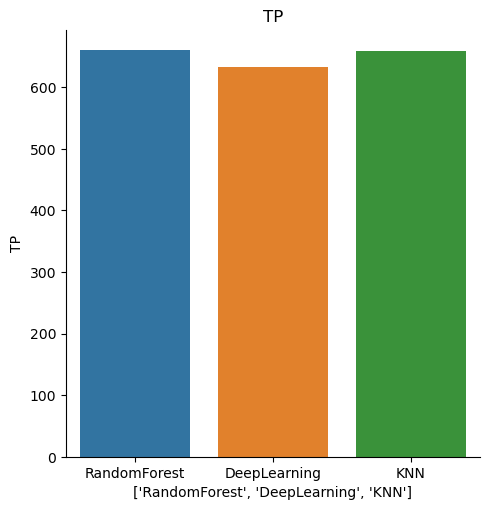

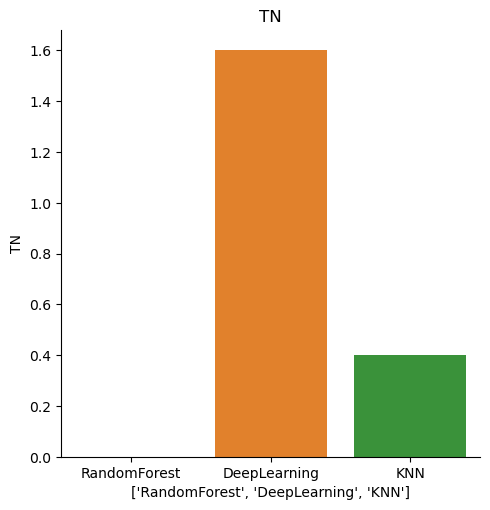

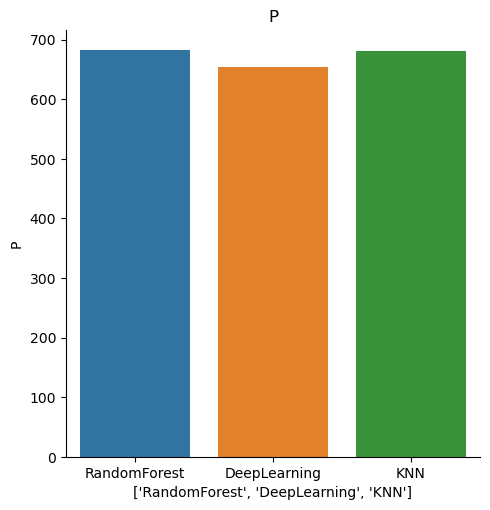

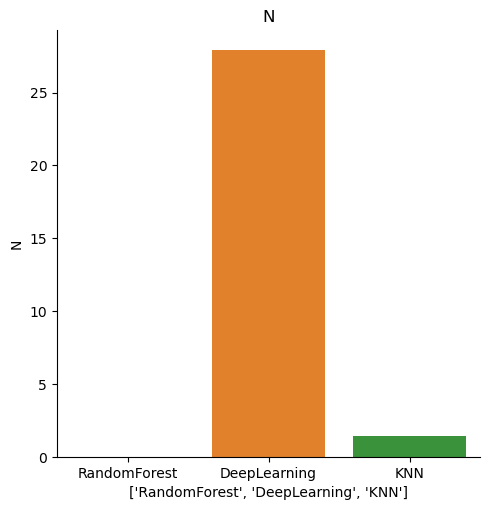

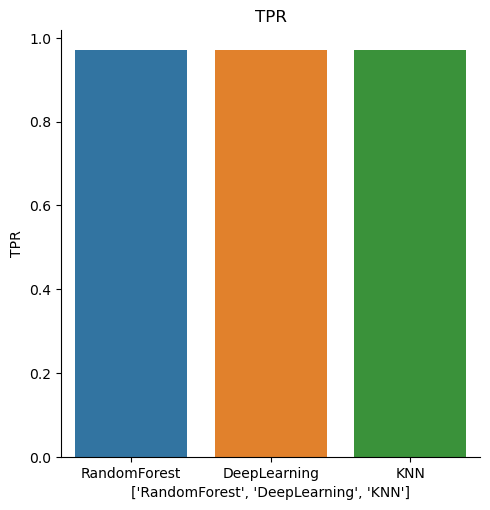

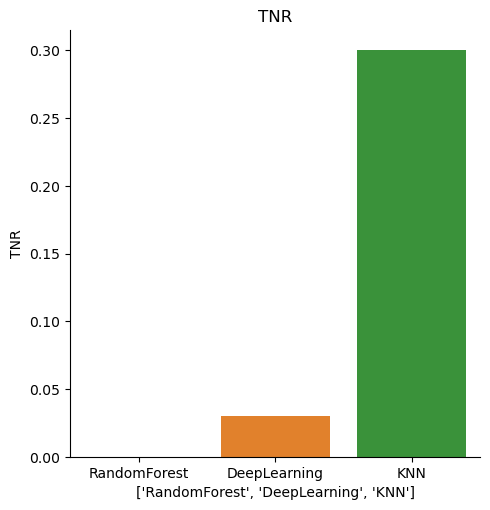

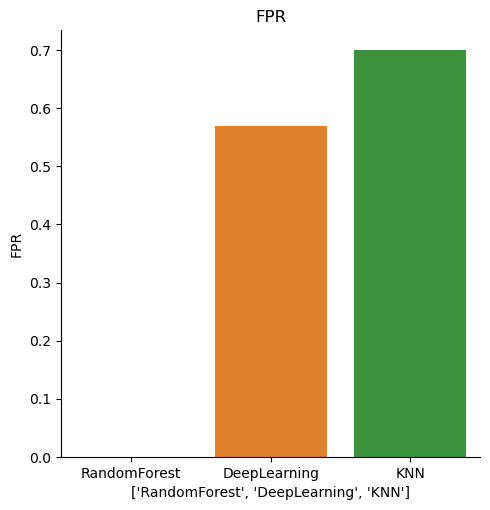

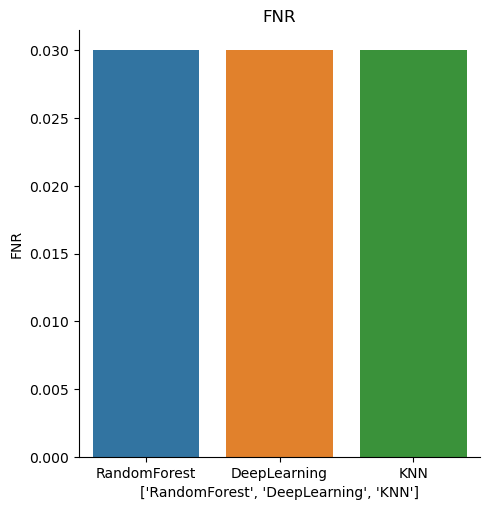

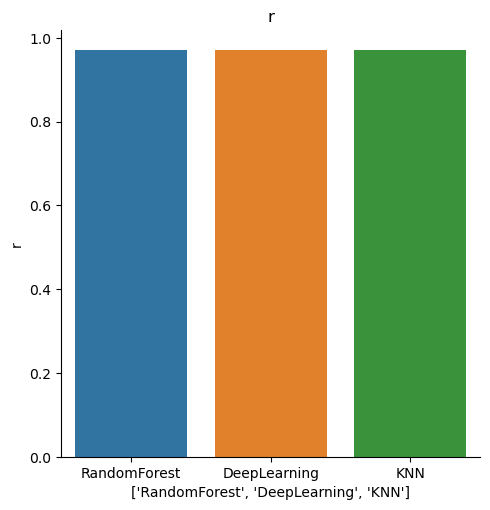

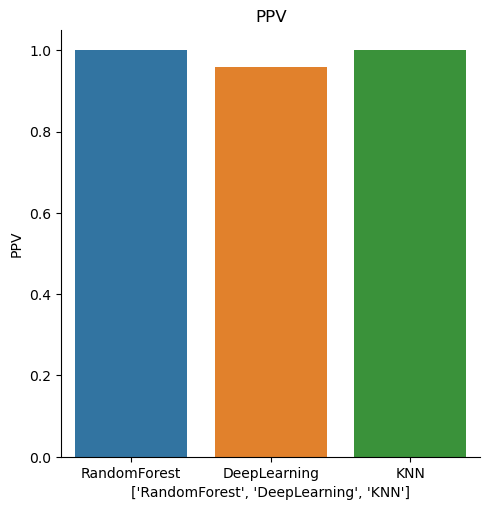

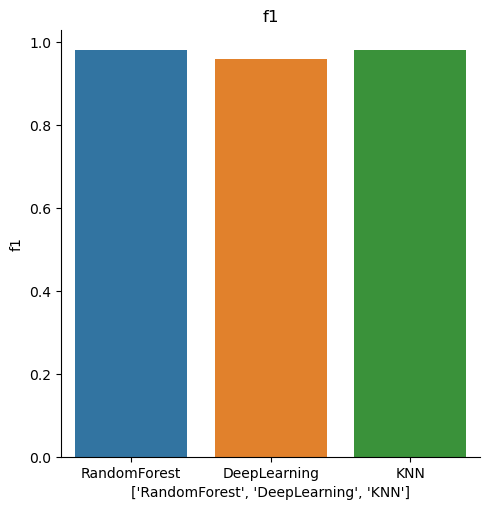

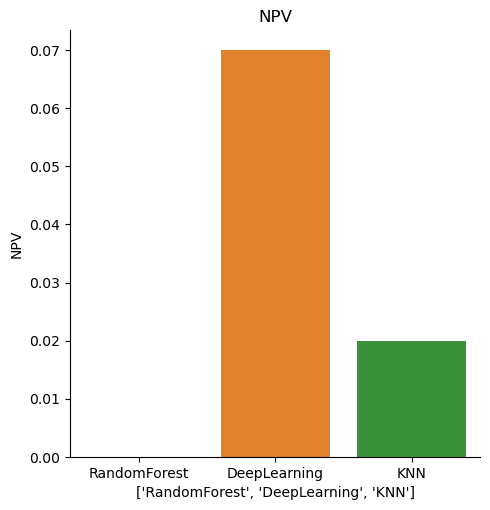

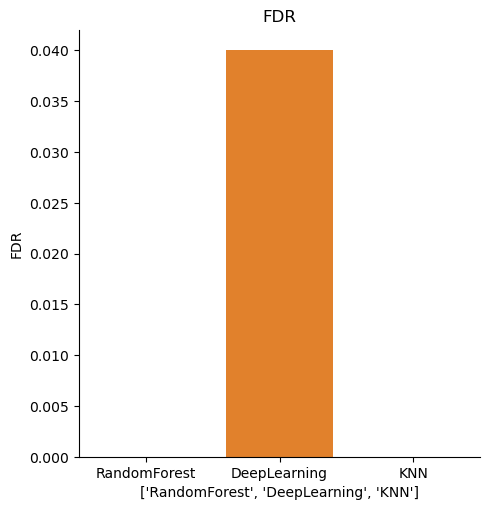

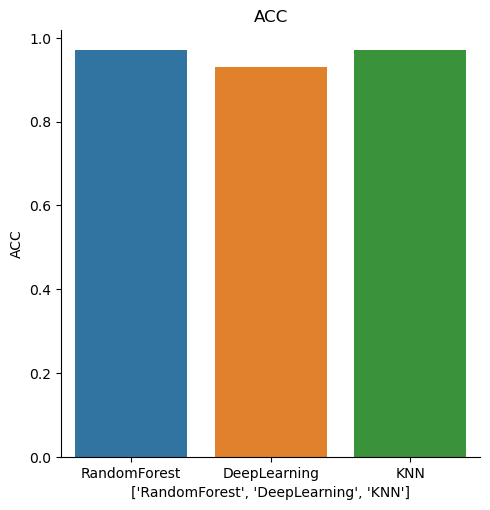

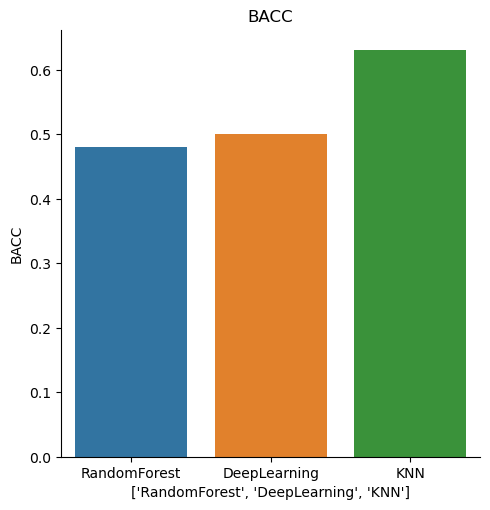

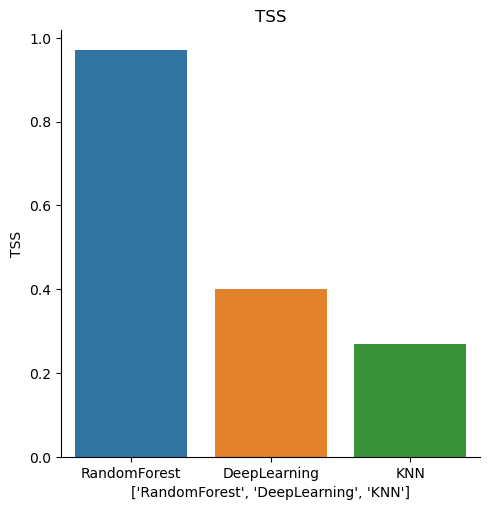

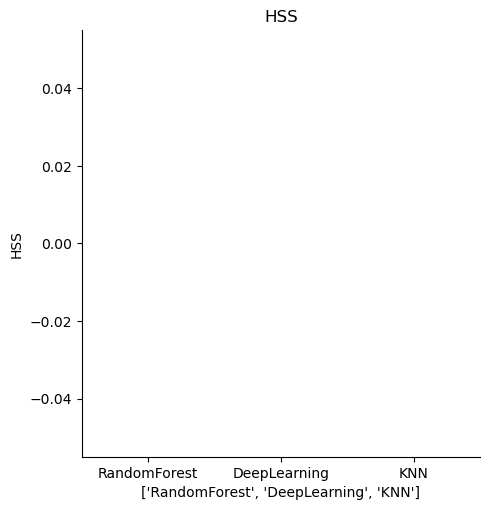

In [31]:
# Display Vars

for i, col in enumerate(df_classifier_metrics_avg.columns):

        # Display Each Metric Comparison               
        sns.catplot(x = df_classifier_metrics_avg.index.tolist(), 
                    y = col, 
                    data = df_classifier_metrics_avg, 
                    kind = 'bar').set(title = col)
        # Testing
        plt.savefig("pics/" + str(i) + ".png", bbox_inches = 'tight')
        
        plt.show()
        plt.close()
        

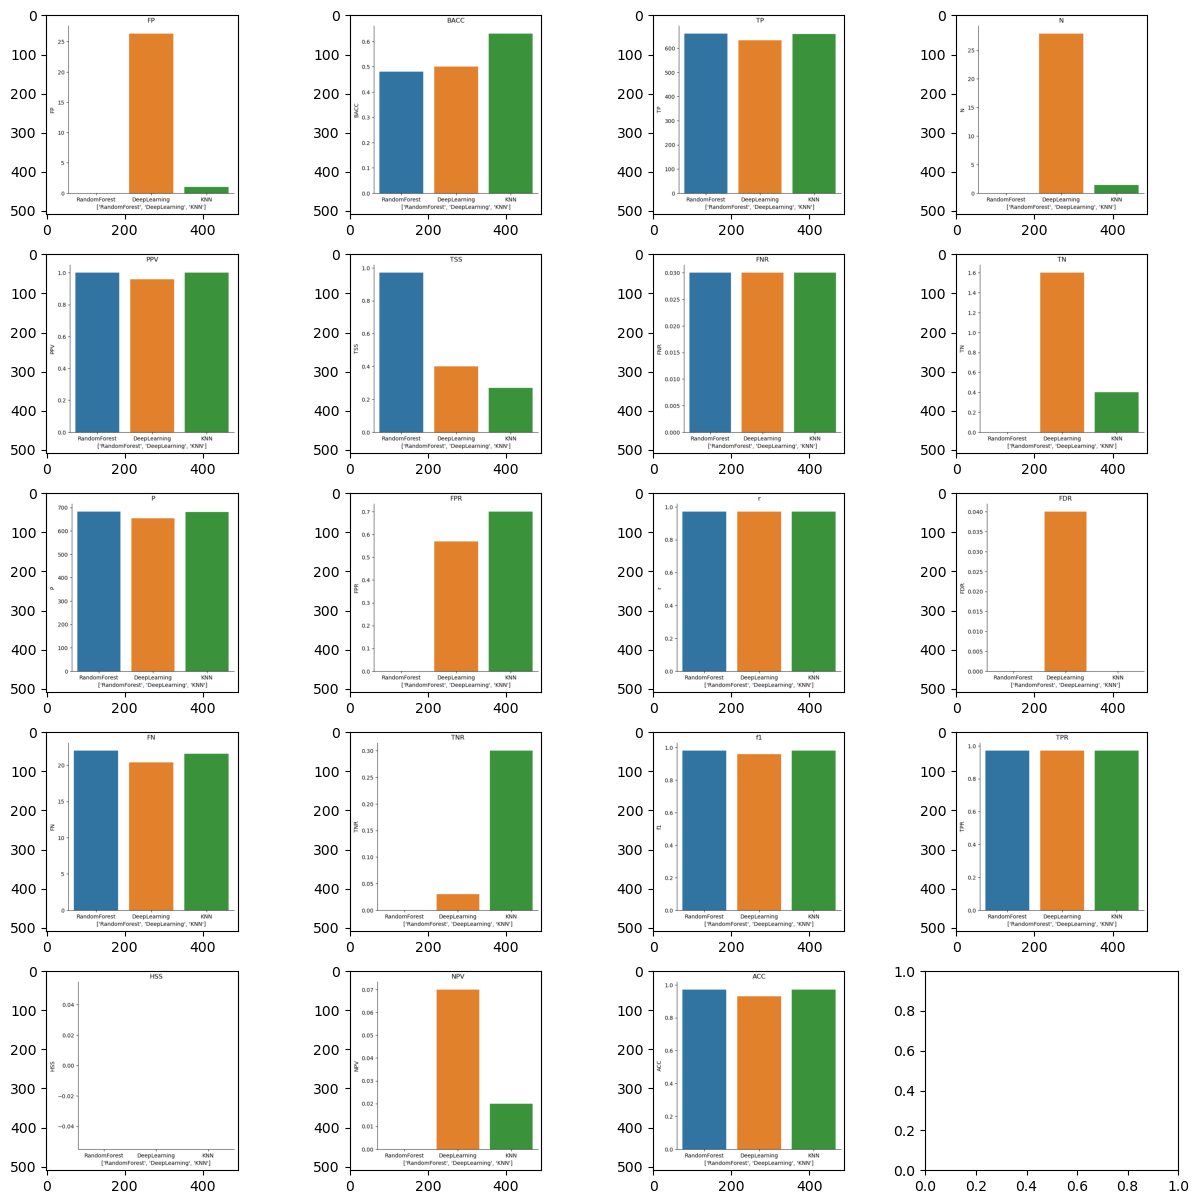

In [32]:
images = os.listdir("pics")

holder = {}

fig, axes = plt.subplots(5,4, figsize=(15, 15))

axes = axes.flatten()

for i, image in enumerate(images):
    
    show_it = plt.imread('pics/' + image)
    
    axes[i].imshow(show_it)

    

## Discusion


The Company Bankruptcy Prediction dataset from Kaggle was used.
https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

A description of the dataset can be found in EDA portion of the notebook above.  The dataset has 96 fields and 6819 entries of int and float values.  The 'bankruptcy' field was used as our label and consists of binary values {0,1} representing solvent (0) and bankrupt(1).



RandomForestClassifier and KNeighborsClassifier from ScikitLearn were used for Random Forest and KNN classifiers.  Keras LSTM Classifier was used for the Deep Learning classifier.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM



Each classifier was trained and evaluated using the 10-Fold Cross Validation Method.
Each run's metrics were stored, and all were averaged together to give the overal reported performance of the classifier.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
    

We can see that the KNN classifier produced the best results over several metrics, followed by Random Forest and DeepLearning classifiers.  Of note KNN met or outperformed on a basket of {FN, TNR, FPR, BACC} metrics.

Each Classifier performed well with accuracies all above 0.9.  There is some concern for overfitting, though validation performed well as well.  The data is from an intentionally useable set from Kaggle.  This should help elucidate the performance of each classifier.  However, it may not fully highlight each classifier's strengths and weaknesses.

Given the source of data and performance of each classifier it is conceivable that thse results will change upon further iterations.  These analyses are valid for the specific run that generated their data.  However, similar results are expected over multiple runs of code.  Please see associated presentation materials for a more full comparison.
